# WordVector Visualization
Goals of this project:
1. Gather word pairs and associated word vectors to be used for downstream methods development and validation. Word vectors are extracted from BioWordVec model and loaded using Gensim: https://www.nature.com/articles/s41597-019-0055-0. Each word pair pairs a cell type word and a marker gene word that relates to each other based on the data from PanglaoDB: https://panglaodb.se
2. For marker gene words, different variations of the same word can be found in the model. Variations include single/plural forms, all letters in upper/lower case, initial letter in upper/lower case, etc. We want to know if variations of the same word have similar word vectors or not. Firstly, we reduce the original 200-dimentions word vectors to 2-dimentions using PCA and TSNE with different settings. Then, we plot those 2-D points using matplotlib scatter plots. We want to see whether points of words that are variations of the same words appear to cluster together or not.

### Import dependencies

In [1]:
import csv
import pandas as pd
from gensim.models import KeyedVectors as KV
import json
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pandasql import sqldf
import matplotlib.colors as colors

In [2]:
pysqldf = lambda q: sqldf(q, globals())

In [3]:
# Colors for plotting
MANY_COLORS = [
    "#0652ff", #  electric blue             
    "#e50000", #  red                       
    "#9a0eea", #  violet                    
    "#01b44c", #  shamrock       
    "#fedf08", #  dandelion                 
    "#00ffff", #  cyan                      
    "#89fe05", #  lime green                
    "#a2cffe", #  baby blue                 
    "#dbb40c", #  gold                      
    "#029386", #  teal                      
    "#ff9408", #  tangerine                 
    "#d8dcd6", #  light grey                
    "#80f9ad", #  seafoam                   
    "#3d1c02", #  chocolate                 
    "#fffd74", #  butter yellow             
    "#536267", #  gunmetal
    "#f6cefc", #  very light purple
    "#650021", #  maroon
    "#020035", #  midnight blue
    "#b0dd16", #  yellowish green
    "#9d7651", #  mocha
    "#c20078", #  magenta
    "#380282", #  indigo
    "#ff796c", #  salmon
    "#874c62", #  dark muave
    "#02ccfe", #  bright sky blue
    "#5fa052", #  muted green
    "#9a3001", #  auburn
    "#fc2647", #  pinky red
    "#d8863b", #  dull orange
    "#7b002c", #  bordeaux
    "#8e82fe", #  periwinkle
    "#ffff14", #  yellow 
    "#ff073a", #  neon red
    "#6ecb3c", #  apple
    "#c45508", #  rust orange
    "#8756e4", #  purpley
    "#8756e4", #  diarrhea
    "#bcecac", #  light sage
    "#5d1451", #  grape purple
    "#028f1e", #  emerald green
    "#ffa62b", #  mango
    "#3a2efe", #  light royal blue
    "#c0022f", #  lipstick red
    "#0485d1", #  cerulean
    "#a57e52", #  puce
    "#380835", #  eggplant
    "#a9f971", #  spring green
    "#fe4b03", #  blood orange
    "#8cff9e", #  baby green
    "#86775f", #  brownish grey
    "#9d0759", #  dark fuchsia
    "#665fd1", #  dark periwinkle
    "#49759c", #  dullblue
    "#fffa86", #  manilla
    "#280137", #  midnight purple
    "#fa4224", #  orangey red
    "#d99b82", #  pinkish tan
    "#152eff", #  vivid blue
    "#f2ab15", #  squash
    "#70b23f", #  nasty green
    "#952e8f", #  warm purple
    "#bcf5a6", #  washed out green
    "#9a6200", #  raw sienna
    "#fb5ffc", #  violet pink
    "#ddd618", #  piss yellow
    "#fe420f", #  orangered
    "#c27e79", #  brownish pink
    "#adf802", #  lemon green
    "#29465b", #  dark grey blue
    "#48c072", #  dark mint
    "#edc8ff"  #  light lilac
]

## Load data, gathering word pairs

In [4]:
with open("raw_data/PanglaoDB_markers_27_Mar_2020.tsv") as file:
    reader = csv.reader(file, delimiter="\t")
    tsvData = list(reader)
    header = tsvData[0]
    data = tsvData[1:]

In [5]:
species = header.index("species")
ogs = header.index("official gene symbol")
ct = header.index("cell type")

In [6]:
VECS_DB = 'raw_data/PubMed-and-PMC-w2v.bin'

In [7]:
#create dictionaries that map cell types to genes
ct_to_genes = {}
ct_to_genes_no_space = {}

for i in data:
    if not "Hs" in i[species]: # Only consider human data
        continue
    if not i[ct] in ct_to_genes:
        ct_to_genes[i[ct]] = []
    ct_to_genes[i[ct]].append(i[ogs])
    
    #replace white space with "-". For example, "b cell" --> "b-cell"
    removeSpace = "-".join(i[ct].split())
    if not removeSpace in ct_to_genes_no_space:
        ct_to_genes_no_space[removeSpace] = []
    ct_to_genes_no_space[removeSpace].append("-".join(i[ogs].split()))
    
with open("output_data/wordpairs.json", 'w', encoding="utf-8") as f:
    json.dump(ct_to_genes, f, indent=2)

In [8]:
print('Loading model...')
model = KV.load_word2vec_format(VECS_DB, binary=True)
print('end')

Loading model...
end


## Process cell type words to get different variations. Save all words and their variations that can be found in the model.

In [9]:
def wordsInModel(ct_to_genes, model, extraCheck=False):
    # Create a set for all the cell type words. 
    our_cell_words = set(ct_to_genes.keys())

    # Initialize an empty set for all the gene words
    our_gene_words = set()
    
    # Add all genes to the set of words
    for genes in ct_to_genes.values():
        our_gene_words.update(genes)
        
    # Get all words in the model    
    model_words = set(list(model.index_to_key))
    
    #Create a set of all words
    our_words = our_cell_words.union(our_gene_words)
    
    record = {}  # Maps words to their variations. Notice that the original word is also 
                 # considered as an instance of variation. Same below.
    cellRecord = {} # Maps cell words to their variations 
    cellTraceOrigin = [] # Record the origin of word variations
    our_words_in_model = [] # All words and their variations that are found in model
    our_cell_words_in_model = [] # All cell words and their variations that are found in model
    count = 0  # The number of words found in the model. A word is considered found if at least one 
               #variation is found in the model
    
    if not extraCheck:
        # No extra word processing. Simply see which words are in the model using set intersection
        our_words_in_model = our_words & model_words
        
    else:
        for i in our_words:
            record[i] = []
            
            # For cell words, they need to be processed since we need to consider multiple variations
            # of a single word. The word "B-cells" will be used as an example of word processing.
            if i in our_cell_words:
                cellRecord[i] = []
                variants = [i]
                
                # If a cell word ends in "s", indicating that it might be in plural form, remove the 
                # ending "s". Example: "B-cells" --> "B-cell"
                if i[-1] == 's':
                    remove_s = i[0:len(i)-1]
                    variants.append(i[0:len(i)-1])
                    
                    # If a cell word ends in "s" and "-" exists, capitalize the initial letter for all
                    # parts of the word separated by "-". Example: "B-cells" --> "B-Cell"
                    if "-" in remove_s:
                        temp = remove_s.split("-")
                        j = 0
                        while j < len(temp):
                            temp[j] = temp[j][0].upper() + temp[j][1:]
                            j += 1
                        variants.append("-".join(temp))
                        
                    variants.append(remove_s.upper()) # Example: "B-cells" --> "B-CELL"
                    variants.append(remove_s.lower()) # Example: "B-cells" --> "b-cell"
                
                # Keep the ending "s" as part of the word.
                # If "-" exists in a cell word, capitalize the initial letter for all parts of the word 
                # separated by "-". Example: "B-cells" --> "B-Cells"
                if "-" in i:
                    temp = i.split("-")
                    j = 0
                    while j < len(temp):
                        temp[j] = temp[j][0].upper() + temp[j][1:]
                        j += 1
                    variants.append("-".join(temp))
                    
                variants.append(i.upper()) # Example: "B-cells" --> "B-CELLS"
                variants.append(i.lower()) # Example: "B-cells" --> "b-cells"
                
                variants = list(set(variants)) # Eliminate duplicates if duplicate exists in all variations
                
                found = False 
                for j in variants:
                    if j in model_words:
                        
                        # Update all records
                        our_words_in_model.append(j)
                        our_cell_words_in_model.append(j)
                        record[i].append(j)
                        cellRecord[i].append(j)
                        cellTraceOrigin.append(i)
                        found = True
                
                # If at least one variation of a word is found in model, that word will be considered as found.
                if found:
                    count += 1
                    
            else:
                
                # For gene words, no processing needed.
                if i in model_words:
                    our_words_in_model.append(i)
                    record[i].append(i)
                    count += 1
            
    
    # Sort the words so we have set order
    our_words_in_model = sorted(our_words_in_model)

    if not extraCheck:
        # print % of words found in the model without considering variations of cell type words
        print(len(our_words_in_model) / len(our_words)) 
        return our_words_in_model
    else: 
        # print % of words found in the model with taking variations of cell type words into account
        print(count / len(our_words))
        return (our_words_in_model, record, cellRecord, our_cell_words_in_model, cellTraceOrigin)
    


In [10]:
raw = wordsInModel(ct_to_genes, model) # Get a list of words found in model, without any processing

# Get a list of words found in the model, after replacing whitespace with "-" for all words
processed = wordsInModel(ct_to_genes_no_space, model) 

# Get a list of words and their variations that are found in the model, after replacing whitespace 
# with "-" for all original words
carefullyProcessed = wordsInModel(ct_to_genes_no_space, model, extraCheck = True) 

# All data analysis below will be based on the carefullyProcessed word data
with open("output_data/availableWords.json", 'w', encoding="utf-8") as f:
    json.dump(carefullyProcessed[1], f, indent=2)

with open("output_data/availableCellWords.json", 'w', encoding="utf-8") as f:
    json.dump(carefullyProcessed[2], f, indent=2)

0.8945390227724961
0.8980314089803141
0.9062154390621544


## Extract cell type word vectors from the model

In [11]:
our_words_in_model = carefullyProcessed[0]

# Get the vectors for all words (including gene words and cell words, storing them in a dataframe)
word_vectors = model[our_words_in_model]
df_vecs = pd.DataFrame(
    data=word_vectors,
    index=our_words_in_model
)

df_vecs

0         1         2         3         4         5    \
A1CF             0.126965 -0.053982  0.052828 -0.115967  0.003116 -0.011743   
A2M              0.043062 -0.020651 -0.223887  0.216093  0.046786  0.090489   
A4GALT           0.352544  0.045117  0.167398 -0.141675  0.183696  0.192712   
AAK1             0.024964 -0.086716  0.722059 -0.179381  0.013219 -0.192339   
AANAT           -0.144345  0.770383  0.204249  0.394394  0.293064  0.199865   
...                   ...       ...       ...       ...       ...       ...   
thymocytes      -0.052995  0.094041  0.086035  0.340184  0.518706  0.180656   
transient-cell  -0.025298  0.005610 -0.076163  0.046844 -0.009767 -0.058379   
trichocyte       0.370683 -0.127052 -0.138680  0.048236  0.191946 -0.040095   
trichocytes      0.329112 -0.196278 -0.094561  0.160227  0.066505  0.163737   
urothelial-cell  0.064035  0.060630 -0.132994  0.050190  0.001552 -0.077105   

                      6         7         8         9    ...       190  \
A1CF            -0.080152 -0.054015 -0.022202 -0.056984  ...  0.007029   
A2M             -0.193671 -0.103313 -0.266569  0.254683  ...  0.521480   
A4GALT           0.023949 -0.006305  0.086083  0.142051  ...  0.274636   
AAK1            -0.345265 -0.178587  0.243234 -0.318207  ...  0.118335   
AANAT            0.068605 -0.277821  0.219555  0.373291  ...  0.246455   
...                   ...       ...       ...       ...  ...       ...   
thymocytes       0.021017  0.472949 -0.025727 -0.119801  ... -0.428107   
transient-cell  -0.006244 -0.037143 -0.055477 -0.039210  ... -0.025612   
trichocyte      -0.162505 -0.116853  0.107280  0.090523  ...  0.048669   
trichocytes      0.134396 -0.156613  0.065823 -0.127598  ... -0.218852   
urothelial-cell -0.027279 -0.110989  0.010975  0.002425  ... -0.125350   

                      191       192       193       194       195       196  \
A1CF             0.006320  0.088674  0.086890 -0.049051  0.125151  0.021630   
A2M              0.103745  0.011137  0.284904 -0.348060 -0.017636 -0.117290   
A4GALT           0.002263  0.003440  0.129859 -0.013859  0.179209 -0.078924   
AAK1             0.187178  0.251875  0.236541 -0.222214  0.386245 -0.069239   
AANAT            0.014465 -0.205537 -0.032852 -0.125959  0.111067  0.060652   
...                   ...       ...       ...       ...       ...       ...   
thymocytes      -0.057990  0.073491  0.513170  0.236919  0.184389 -0.150840   
transient-cell  -0.024288  0.001166 -0.061643  0.024322 -0.060356 -0.047187   
trichocyte       0.074613  0.015143  0.133200  0.044292 -0.202400 -0.088129   
trichocytes      0.133336  0.215017  0.100869  0.195171 -0.061878 -0.063114   
urothelial-cell -0.078466  0.065154 -0.046250  0.117593 -0.126905 -0.015901   

                      197       198       199  
A1CF            -0.000391 -0.022193  0.057105  
A2M             -0.033145 -0.172929  0.145889  
A4GALT           0.005615 -0.044540  0.063947  
AAK1             0.027313 -0.285188 -0.054491  
AANAT           -0.182649  0.136331  0.232900  
...                   ...       ...       ...  
thymocytes       0.483863  0.092041  0.157061  
transient-cell   0.039963  0.028763 -0.086154  
trichocyte       0.033434  0.204544 -0.038069  
trichocytes      0.028525  0.166973 -0.137808  
urothelial-cell  0.054384  0.150546 -0.111652  

[4336 rows x 200 columns]

In [12]:
# Get the vectors for cell words, storing them in a dataframe
our_cell_words_in_model = carefullyProcessed[3]
cell_word_vectors = model[our_cell_words_in_model]
df_cell_vecs = pd.DataFrame(
    data=cell_word_vectors,
    index=our_cell_words_in_model
)

# Add origin column to specify the original word
df_cell_vecs["origin"] = carefullyProcessed[4]
df_cell_vecs["index"] = df_cell_vecs.index # Make a column that contains indices of each row

# Write the data to a file
df_cell_vecs.to_csv('output_data/cell_type_word_vecs.tsv', sep='\t')

df_cell_vecs

0         1         2         3         4         5  \
Hepatoblast    -0.012928 -0.021765 -0.050547  0.010147  0.005202  0.041475   
hepatoblasts   -0.031398 -0.077502 -0.166781  0.003611  0.189983  0.269697   
Hepatoblasts    0.041439 -0.012526 -0.063098 -0.098464  0.145807 -0.014270   
hepatoblast     0.040604  0.045963 -0.261603 -0.101383 -0.075713  0.470565   
B-CELL          0.096903  0.011132  0.003009 -0.049386 -0.241107 -0.013200   
...                  ...       ...       ...       ...       ...       ...   
transient-cell -0.025298  0.005610 -0.076163  0.046844 -0.009767 -0.058379   
mast-cells     -0.181021  0.181512 -0.232548  0.108751  0.007954  0.251440   
mast-cell      -0.231894  0.340511 -0.138098  0.080069 -0.217502  0.077494   
Mast-cell      -0.109165  0.165711 -0.244754  0.062117 -0.122026 -0.022741   
Mast-Cell       0.075703  0.025087 -0.092814  0.005038 -0.010510  0.055030   

                       6         7         8         9  ...       192  \
Hepatoblast     0.010037  0.003633 -0.011596 -0.037206  ...  0.040009   
hepatoblasts   -0.042699  0.346597 -0.151893 -0.449113  ...  0.583816   
Hepatoblasts   -0.026641 -0.045975  0.149996 -0.127738  ...  0.170562   
hepatoblast    -0.147258 -0.080401 -0.151977 -0.547724  ...  0.752746   
B-CELL         -0.147822 -0.058586  0.056578 -0.125223  ...  0.095927   
...                  ...       ...       ...       ...  ...       ...   
transient-cell -0.006244 -0.037143 -0.055477 -0.039210  ...  0.001166   
mast-cells     -0.031917 -0.135721  0.006335 -0.338338  ...  0.205242   
mast-cell      -0.128386 -0.184196 -0.173747 -0.215831  ...  0.128849   
Mast-cell      -0.124239 -0.049804  0.078240 -0.211998  ...  0.144052   
Mast-Cell       0.046662  0.076202  0.090902 -0.037046  ...  0.127988   

                     193       194       195       196       197       198  \
Hepatoblast     0.027038  0.006365 -0.025985 -0.036602  0.016413  0.063665   
hepatoblasts    0.123250  0.085619 -0.318701 -0.190686  0.401953  0.167115   
Hepatoblasts    0.233081  0.164579 -0.058493 -0.244387  0.178913 -0.146193   
hepatoblast     0.021060 -0.146941 -0.238531 -0.192631  0.305604  0.103160   
B-CELL         -0.197289 -0.090047  0.280226 -0.052025 -0.128074  0.114324   
...                  ...       ...       ...       ...       ...       ...   
transient-cell -0.061643  0.024322 -0.060356 -0.047187  0.039963  0.028763   
mast-cells      0.100631  0.251055  0.067435  0.112590  0.077421 -0.047308   
mast-cell       0.082952 -0.076701 -0.001527 -0.023512 -0.122164 -0.347906   
Mast-cell       0.234190  0.144785 -0.114241 -0.029123  0.080327 -0.104510   
Mast-Cell       0.077769  0.008395  0.049466 -0.026225 -0.042762 -0.091794   

                     199           origin           index  
Hepatoblast     0.007694     Hepatoblasts     Hepatoblast  
hepatoblasts   -0.124848     Hepatoblasts    hepatoblasts  
Hepatoblasts   -0.093326     Hepatoblasts    Hepatoblasts  
hepatoblast    -0.108116     Hepatoblasts     hepatoblast  
B-CELL         -0.045572          B-cells          B-CELL  
...                  ...              ...             ...  
transient-cell -0.086154  Transient-cells  transient-cell  
mast-cells     -0.213819       Mast-cells      mast-cells  
mast-cell       0.067096       Mast-cells       mast-cell  
Mast-cell      -0.025320       Mast-cells       Mast-cell  
Mast-Cell       0.014783       Mast-cells       Mast-Cell  

[332 rows x 202 columns]

In [13]:
# Only keep entries in the dataset whose origin word has at least three variations found in the model
q = """
SELECT * FROM df_cell_vecs
WHERE origin IN (SELECT origin FROM df_cell_vecs
GROUP BY origin
HAVING COUNT(0) > 2)
"""

df_cell_vecs = pysqldf(q)
# pysqldf does not preserve original index. Recover index.
df_cell_vecs = df_cell_vecs.set_index("index") 
df_cell_vecs

0         1         2         3         4         5  \
index                                                                      
Hepatoblast  -0.012928 -0.021765 -0.050547  0.010147  0.005202  0.041475   
hepatoblasts -0.031398 -0.077502 -0.166781  0.003611  0.189983  0.269697   
Hepatoblasts  0.041439 -0.012526 -0.063098 -0.098464  0.145807 -0.014270   
hepatoblast   0.040604  0.045963 -0.261603 -0.101383 -0.075713  0.470565   
B-CELL        0.096903  0.011132  0.003009 -0.049386 -0.241107 -0.013200   
...                ...       ...       ...       ...       ...       ...   
Basal-cell    0.263031 -0.038083 -0.390942  0.260803 -0.085456 -0.152730   
mast-cells   -0.181021  0.181512 -0.232548  0.108751  0.007954  0.251440   
mast-cell    -0.231894  0.340511 -0.138098  0.080069 -0.217502  0.077494   
Mast-cell    -0.109165  0.165711 -0.244754  0.062117 -0.122026 -0.022741   
Mast-Cell     0.075703  0.025087 -0.092814  0.005038 -0.010510  0.055030   

                     6         7         8         9  ...       191       192  \
index                                                 ...                       
Hepatoblast   0.010037  0.003633 -0.011596 -0.037206  ... -0.001958  0.040009   
hepatoblasts -0.042699  0.346597 -0.151893 -0.449113  ...  0.090061  0.583816   
Hepatoblasts -0.026641 -0.045975  0.149996 -0.127738  ...  0.036210  0.170562   
hepatoblast  -0.147258 -0.080401 -0.151977 -0.547724  ... -0.038129  0.752746   
B-CELL       -0.147822 -0.058586  0.056578 -0.125223  ...  0.002151  0.095927   
...                ...       ...       ...       ...  ...       ...       ...   
Basal-cell   -0.049903 -0.347902 -0.077696 -0.089819  ...  0.063664  0.313242   
mast-cells   -0.031917 -0.135721  0.006335 -0.338338  ...  0.195032  0.205242   
mast-cell    -0.128386 -0.184196 -0.173747 -0.215831  ...  0.009134  0.128849   
Mast-cell    -0.124239 -0.049804  0.078240 -0.211998  ... -0.058670  0.144052   
Mast-Cell     0.046662  0.076202  0.090902 -0.037046  ... -0.051663  0.127988   

                   193       194       195       196       197       198  \
index                                                                      
Hepatoblast   0.027038  0.006365 -0.025985 -0.036602  0.016413  0.063665   
hepatoblasts  0.123250  0.085619 -0.318701 -0.190686  0.401953  0.167115   
Hepatoblasts  0.233081  0.164579 -0.058493 -0.244387  0.178913 -0.146193   
hepatoblast   0.021060 -0.146941 -0.238531 -0.192631  0.305604  0.103160   
B-CELL       -0.197289 -0.090047  0.280226 -0.052025 -0.128074  0.114324   
...                ...       ...       ...       ...       ...       ...   
Basal-cell   -0.220605  0.162522  0.050788  0.099061  0.031762  0.320703   
mast-cells    0.100631  0.251055  0.067435  0.112590  0.077421 -0.047308   
mast-cell     0.082952 -0.076701 -0.001527 -0.023512 -0.122164 -0.347906   
Mast-cell     0.234190  0.144785 -0.114241 -0.029123  0.080327 -0.104510   
Mast-Cell     0.077769  0.008395  0.049466 -0.026225 -0.042762 -0.091794   

                   199        origin  
index                                 
Hepatoblast   0.007694  Hepatoblasts  
hepatoblasts -0.124848  Hepatoblasts  
Hepatoblasts -0.093326  Hepatoblasts  
hepatoblast  -0.108116  Hepatoblasts  
B-CELL       -0.045572       B-cells  
...                ...           ...  
Basal-cell   -0.221005   Basal-cells  
mast-cells   -0.213819    Mast-cells  
mast-cell     0.067096    Mast-cells  
Mast-cell    -0.025320    Mast-cells  
Mast-Cell     0.014783    Mast-cells  

[288 rows x 201 columns]

In [14]:
#extracts all columns except the origin column
features = list(df_cell_vecs.columns)[0:len(df_cell_vecs.columns)-1]
vectors = df_cell_vecs.loc[:, features].values
origins = df_cell_vecs.loc[:,['origin']].values
labels = df_cell_vecs.index

## Apply dimentionality reduction to word vectors and plot the results

#### Create PCA plots

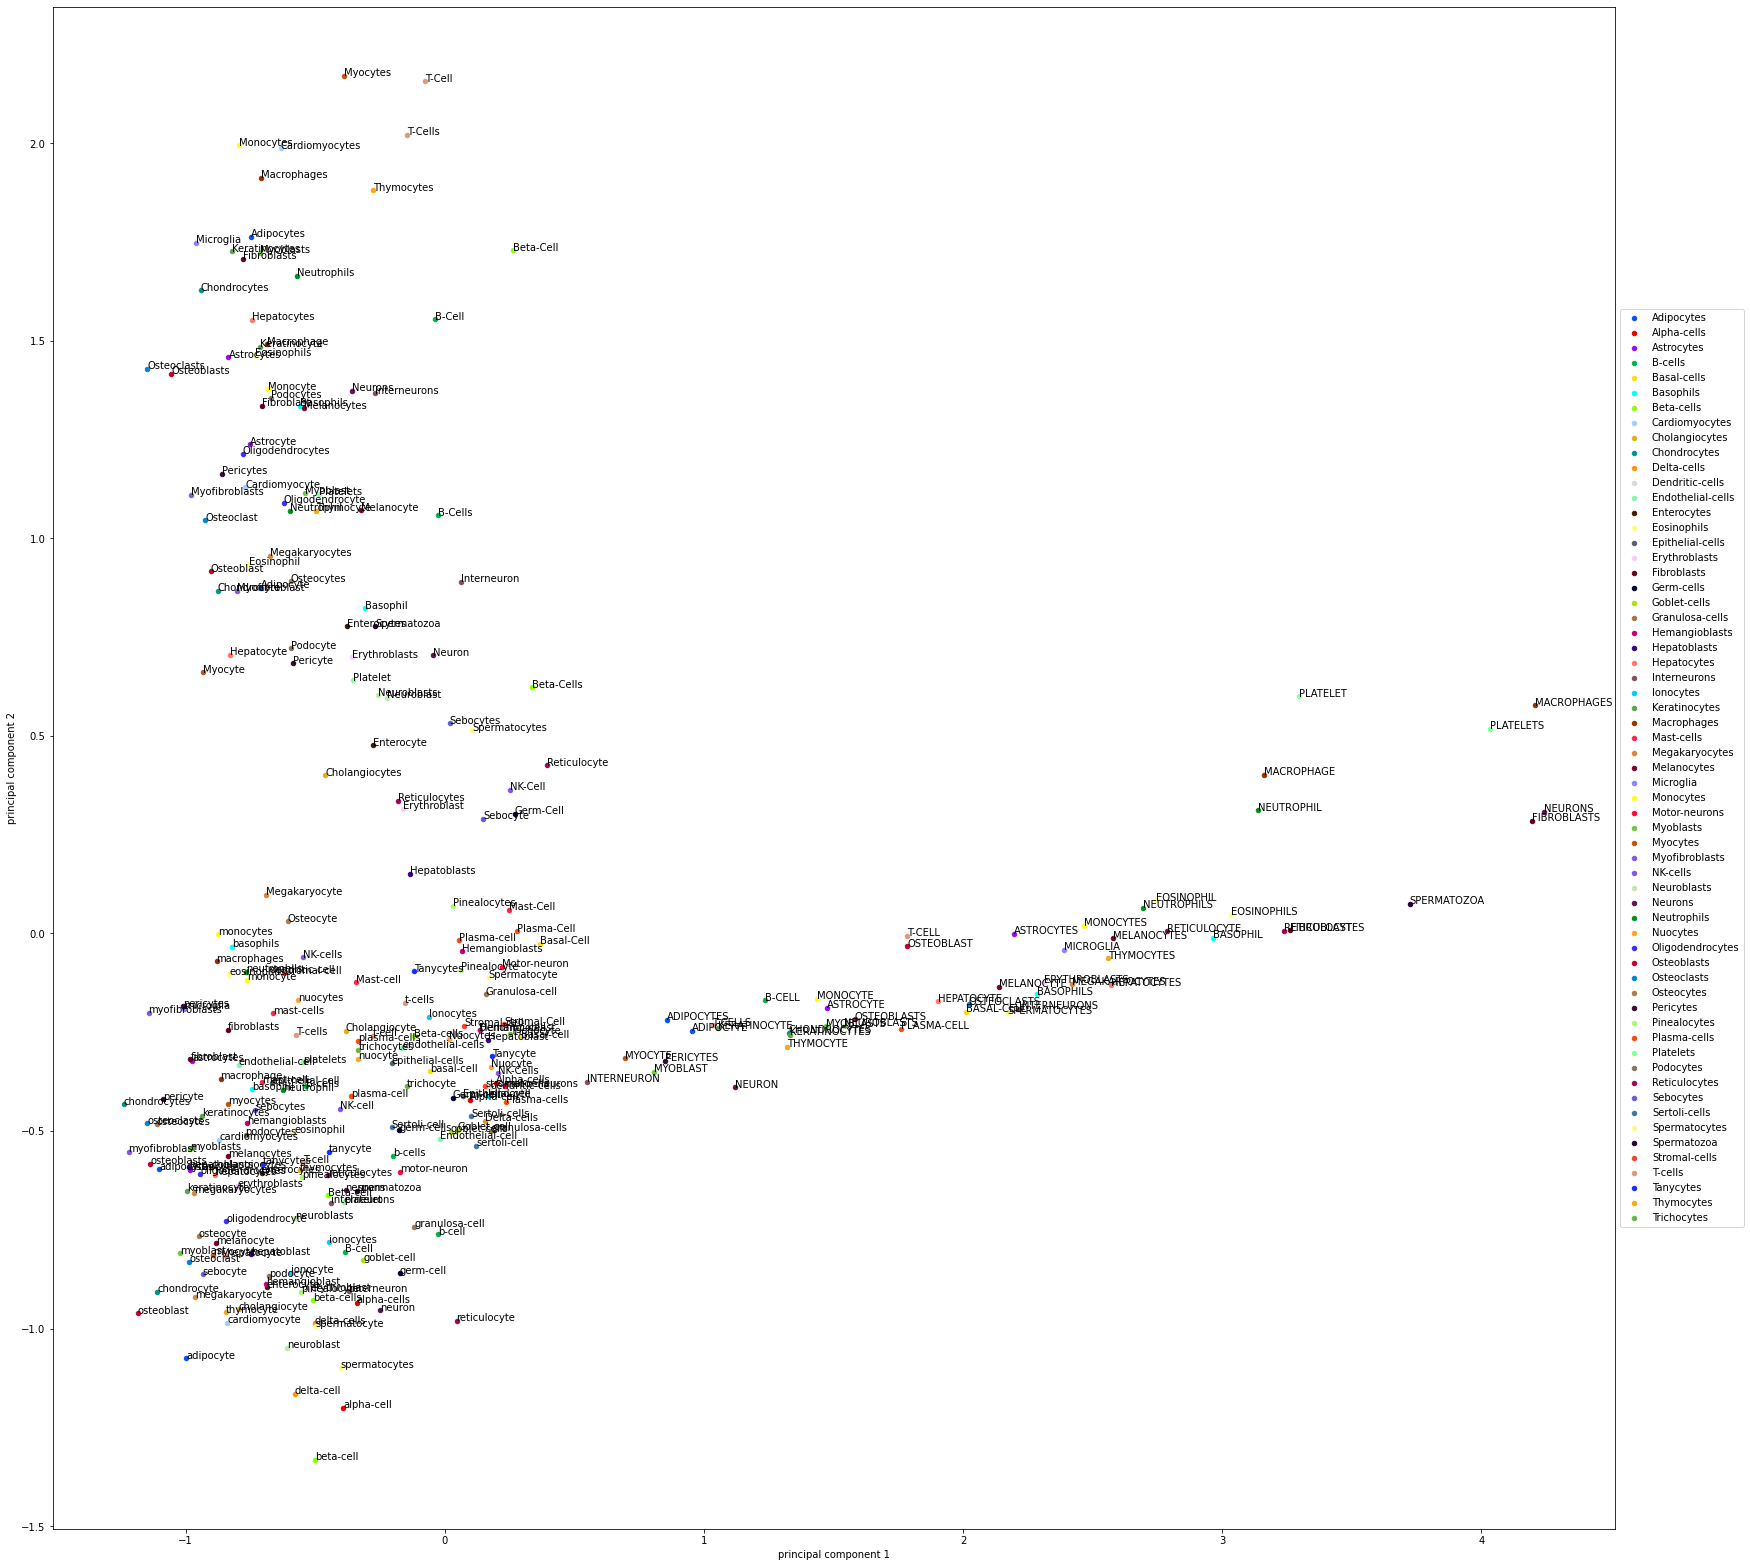

In [15]:
# Apply PCA transformer to the vector dataset, reduce the dimentionality of the data from 200D to 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(vectors)

# Save the dimentionality-reduced data in a dataframe
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'], index = labels)
# Add the origin of each word for plotting purpose
finalDf = pd.concat([principalDf, df_cell_vecs[['origin']]], axis = 1)
finalDf.to_csv('output_data/pca.tsv', sep='\t')

# Variations of the same word will be assigned the same color in the scatter plot
groups = finalDf.groupby("origin")
fig, ax = plt.subplots()
i = 0
for name, group in groups:
    group.plot(kind="scatter", x = "principal component 1", y = "principal component 2", ax=ax, 
               marker="o", label=name, color=MANY_COLORS[i])
    i += 1
for index, row in finalDf.iterrows():
    ax.annotate(index, (row["principal component 1"], row["principal component 2"]))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
figure = plt.gcf()
figure.set_size_inches(28, 28)
plt.savefig("img/PCA.png")

In [16]:
finalDf

principal component 1  principal component 2        origin
index                                                                   
Hepatoblast                0.166583              -0.269232  Hepatoblasts
hepatoblasts              -0.986820              -0.591723  Hepatoblasts
Hepatoblasts              -0.133233               0.150660  Hepatoblasts
hepatoblast               -0.746825              -0.811505  Hepatoblasts
B-CELL                     1.235612              -0.169183       B-cells
...                             ...                    ...           ...
Basal-cell                 0.292517              -0.262668   Basal-cells
mast-cells                -0.664100              -0.201624    Mast-cells
mast-cell                 -0.706694              -0.376626    Mast-cells
Mast-cell                 -0.344083              -0.123323    Mast-cells
Mast-Cell                  0.249474               0.060047    Mast-cells

[288 rows x 3 columns]

#### Create tSNE plot with default metric and perplexity setting

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


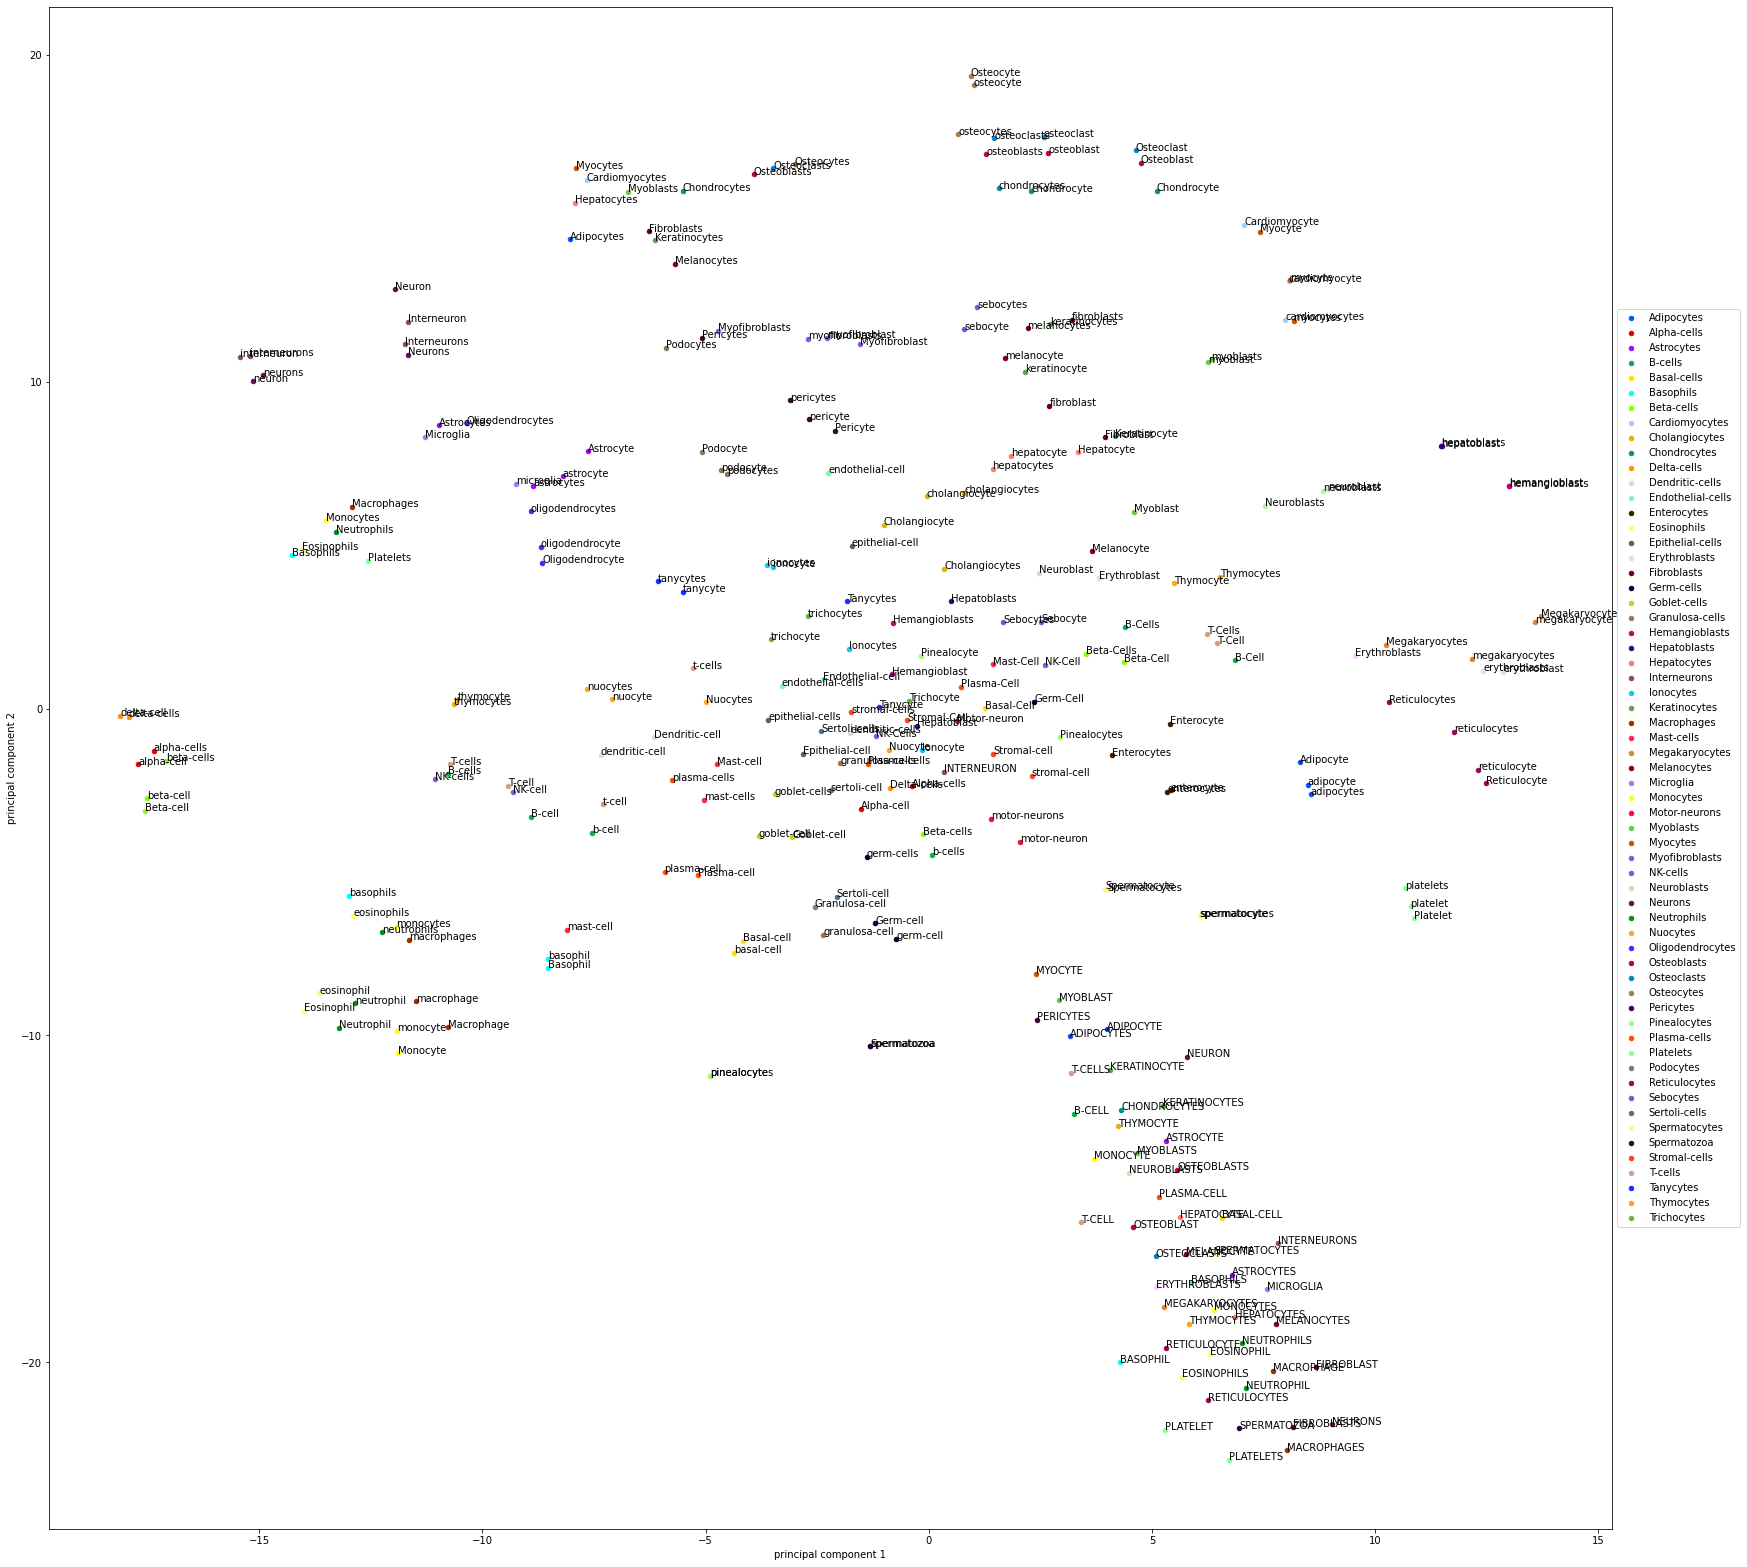

In [17]:
# Do dimensionality reduction using TSNE transformer. The process is the same as PCA.
tsne = TSNE(n_components=2)
principalComponentsTSNE = tsne.fit_transform(vectors)
principalDfTSNE = pd.DataFrame(data = principalComponentsTSNE
             , columns = ['principal component 1', 'principal component 2'], index = labels)
finalDfTSNE = pd.concat([principalDfTSNE, df_cell_vecs[['origin']]], axis = 1)
finalDfTSNE.to_csv('output_data/tsne.tsv', sep='\t')
groupsTSNE = finalDfTSNE.groupby("origin")
fig, ax = plt.subplots()
i = 0
for name, group in groupsTSNE:
    group.plot(kind="scatter", x = "principal component 1", y = "principal component 2", 
               ax=ax, marker="o", label=name, color=MANY_COLORS[i])
    i += 1
for index, row in finalDfTSNE.iterrows():
    ax.annotate(index, (row["principal component 1"], row["principal component 2"]))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
figure = plt.gcf()
figure.set_size_inches(28, 28)
plt.savefig("img/TSNE.png")

In [18]:
finalDfTSNE

principal component 1  principal component 2        origin
index                                                                   
Hepatoblast               -0.257993              -0.526123  Hepatoblasts
hepatoblasts              11.487843               8.040630  Hepatoblasts
Hepatoblasts               0.490360               3.290245  Hepatoblasts
hepatoblast               11.471753               8.024669  Hepatoblasts
B-CELL                     3.261340             -12.390669       B-cells
...                             ...                    ...           ...
Basal-cell                -4.160049              -7.101755   Basal-cells
mast-cells                -5.041811              -2.795629    Mast-cells
mast-cell                 -8.094664              -6.765328    Mast-cells
Mast-cell                 -4.752672              -1.697341    Mast-cells
Mast-Cell                  1.445891               1.349270    Mast-cells

[288 rows x 3 columns]

#### Create tSNE plots with different metric and perplexity settings

In [19]:
# Try different metric (euclidean, cosine) and different perplexity (5, 10, 20, 30) settings for TSNE 
def tSNE(vectors, labels, origin, metric, perplexity):
    tsne = TSNE(n_components=2, metric=metric, perplexity=perplexity)
    principalComponentsTSNE = tsne.fit_transform(vectors)
    principalDfTSNE = pd.DataFrame(data = principalComponentsTSNE
                 , columns = ['principal component 1', 'principal component 2'], index = labels)
    finalDfTSNE = pd.concat([principalDfTSNE, origin], axis = 1)
    groupsTSNE = finalDfTSNE.groupby("origin")
    fig, ax = plt.subplots()
    i = 0
    for name, group in groupsTSNE:
        group.plot(kind="scatter", x = "principal component 1", y = "principal component 2", ax=ax, 
                   marker="o", label=name, color=MANY_COLORS[i])
        i += 1
    for index, row in finalDfTSNE.iterrows():
        ax.annotate(index, (row["principal component 1"], row["principal component 2"]))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    figure = plt.gcf()
    figure.set_size_inches(32, 32)
    plt.savefig("img/TSNE." + str(metric) + "." + str(perplexity) + ".png")

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will

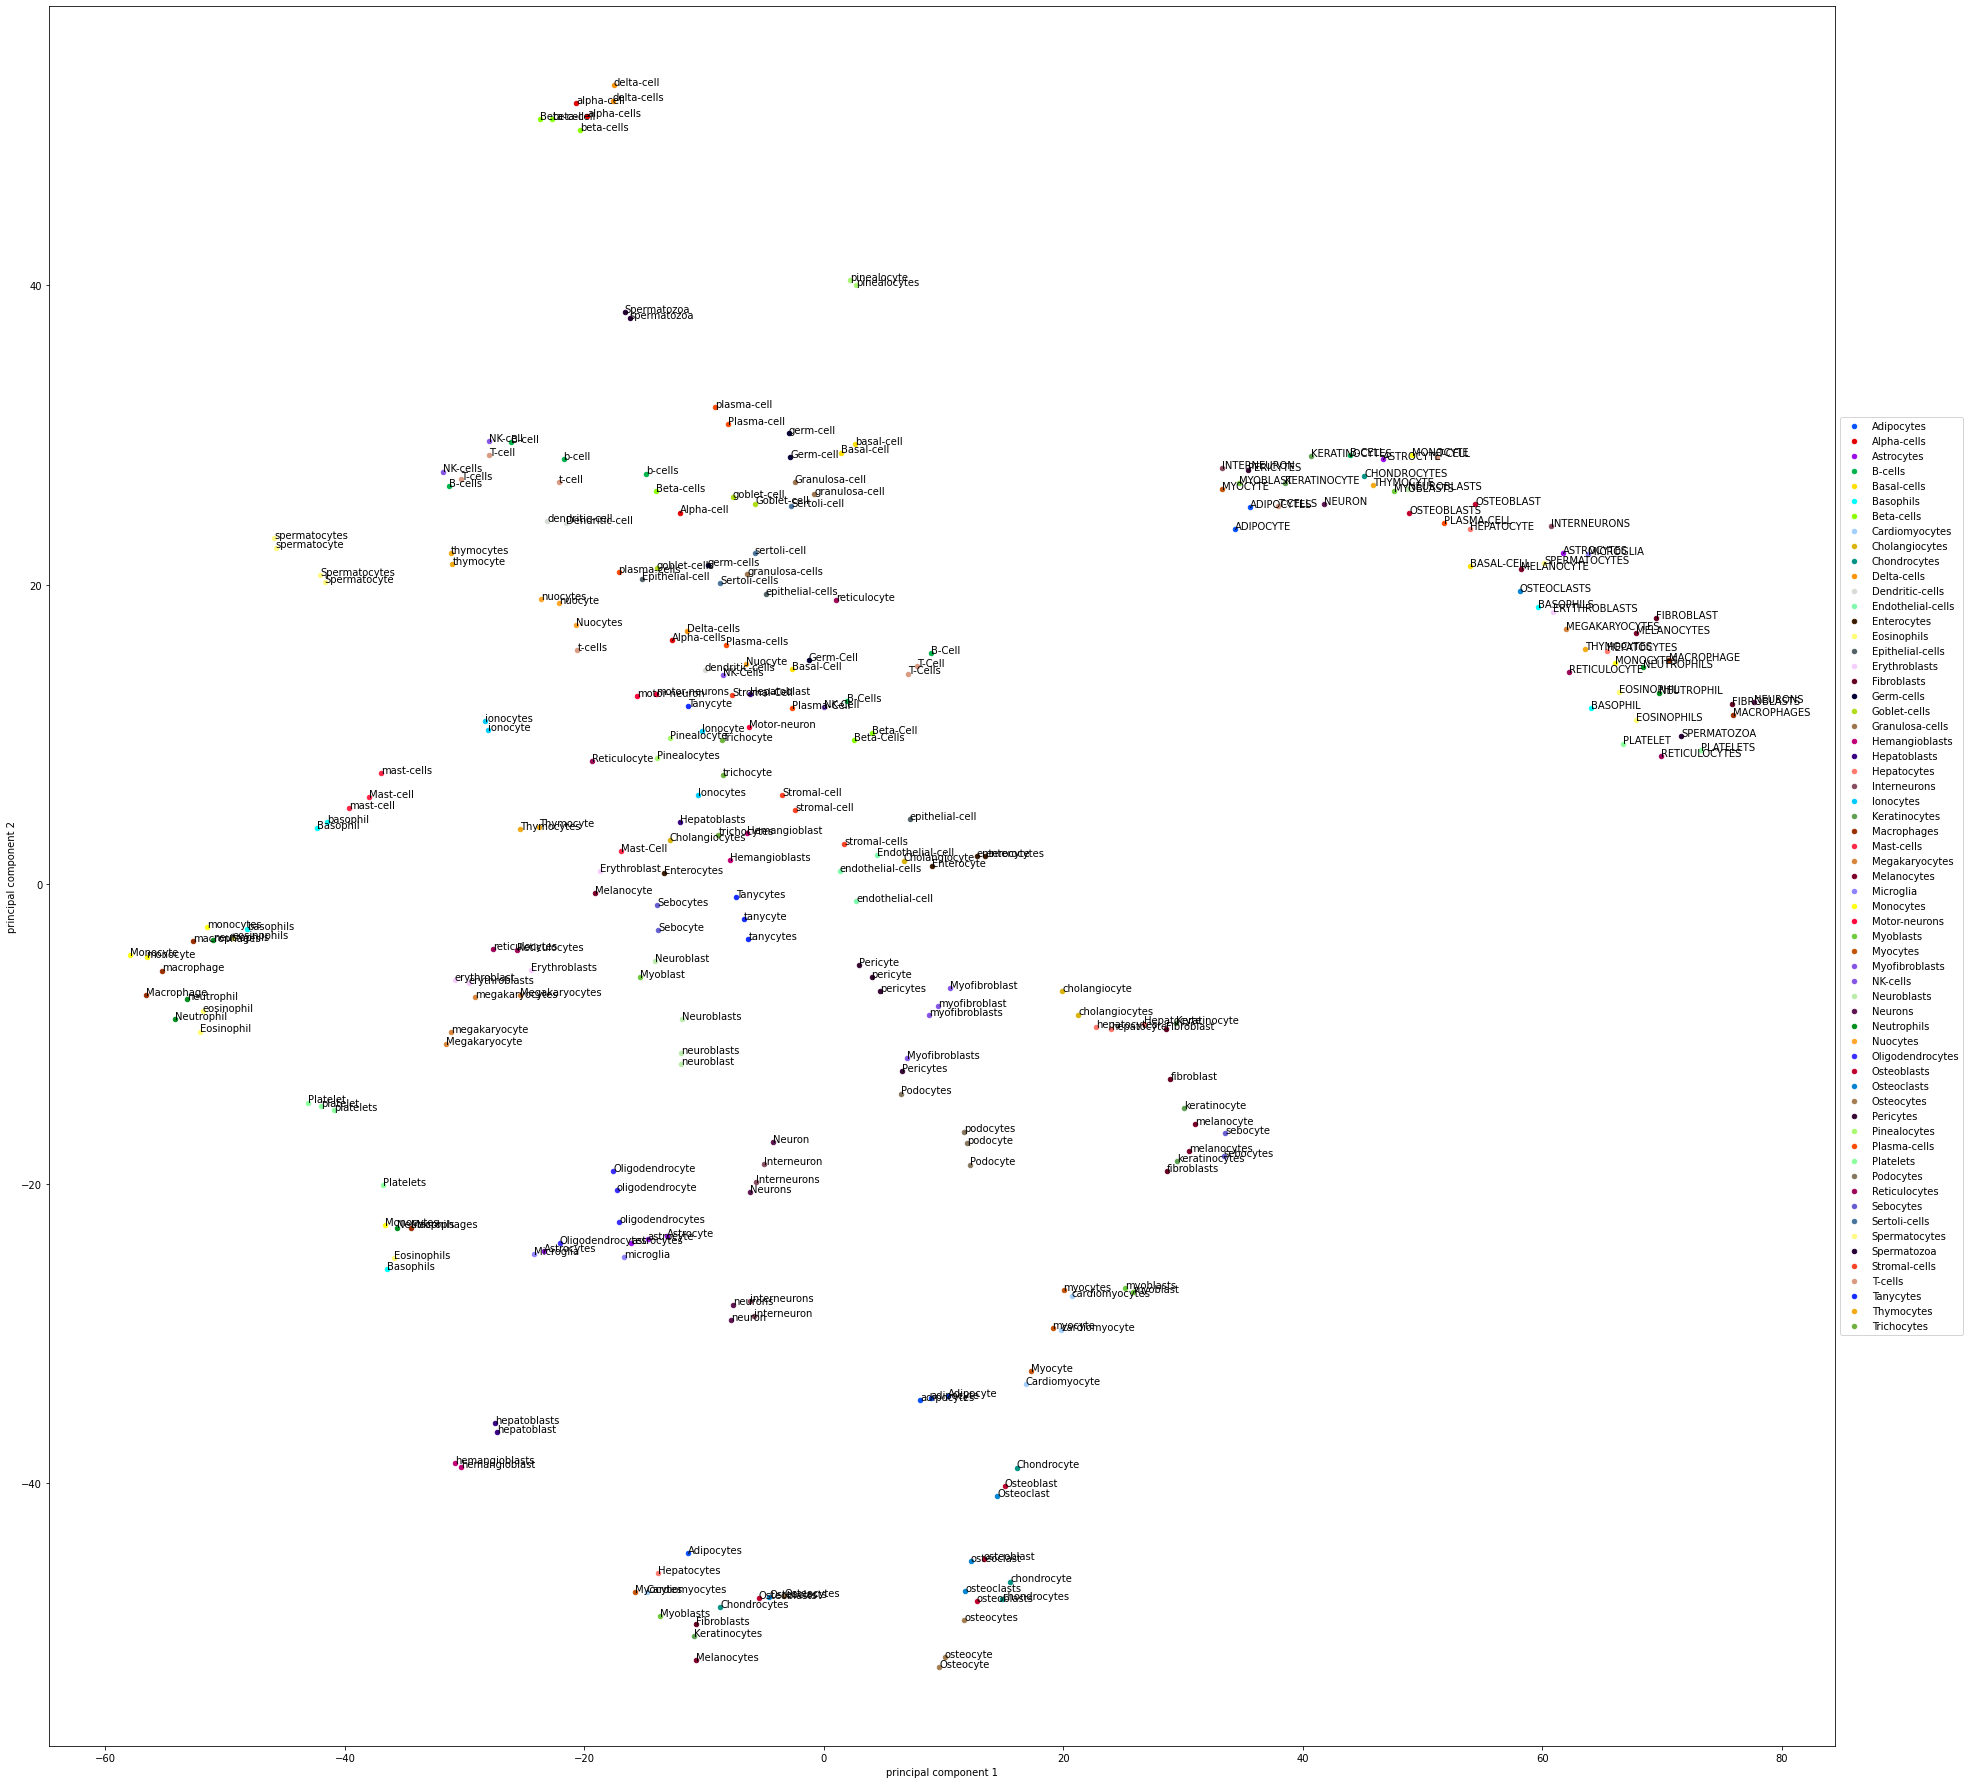

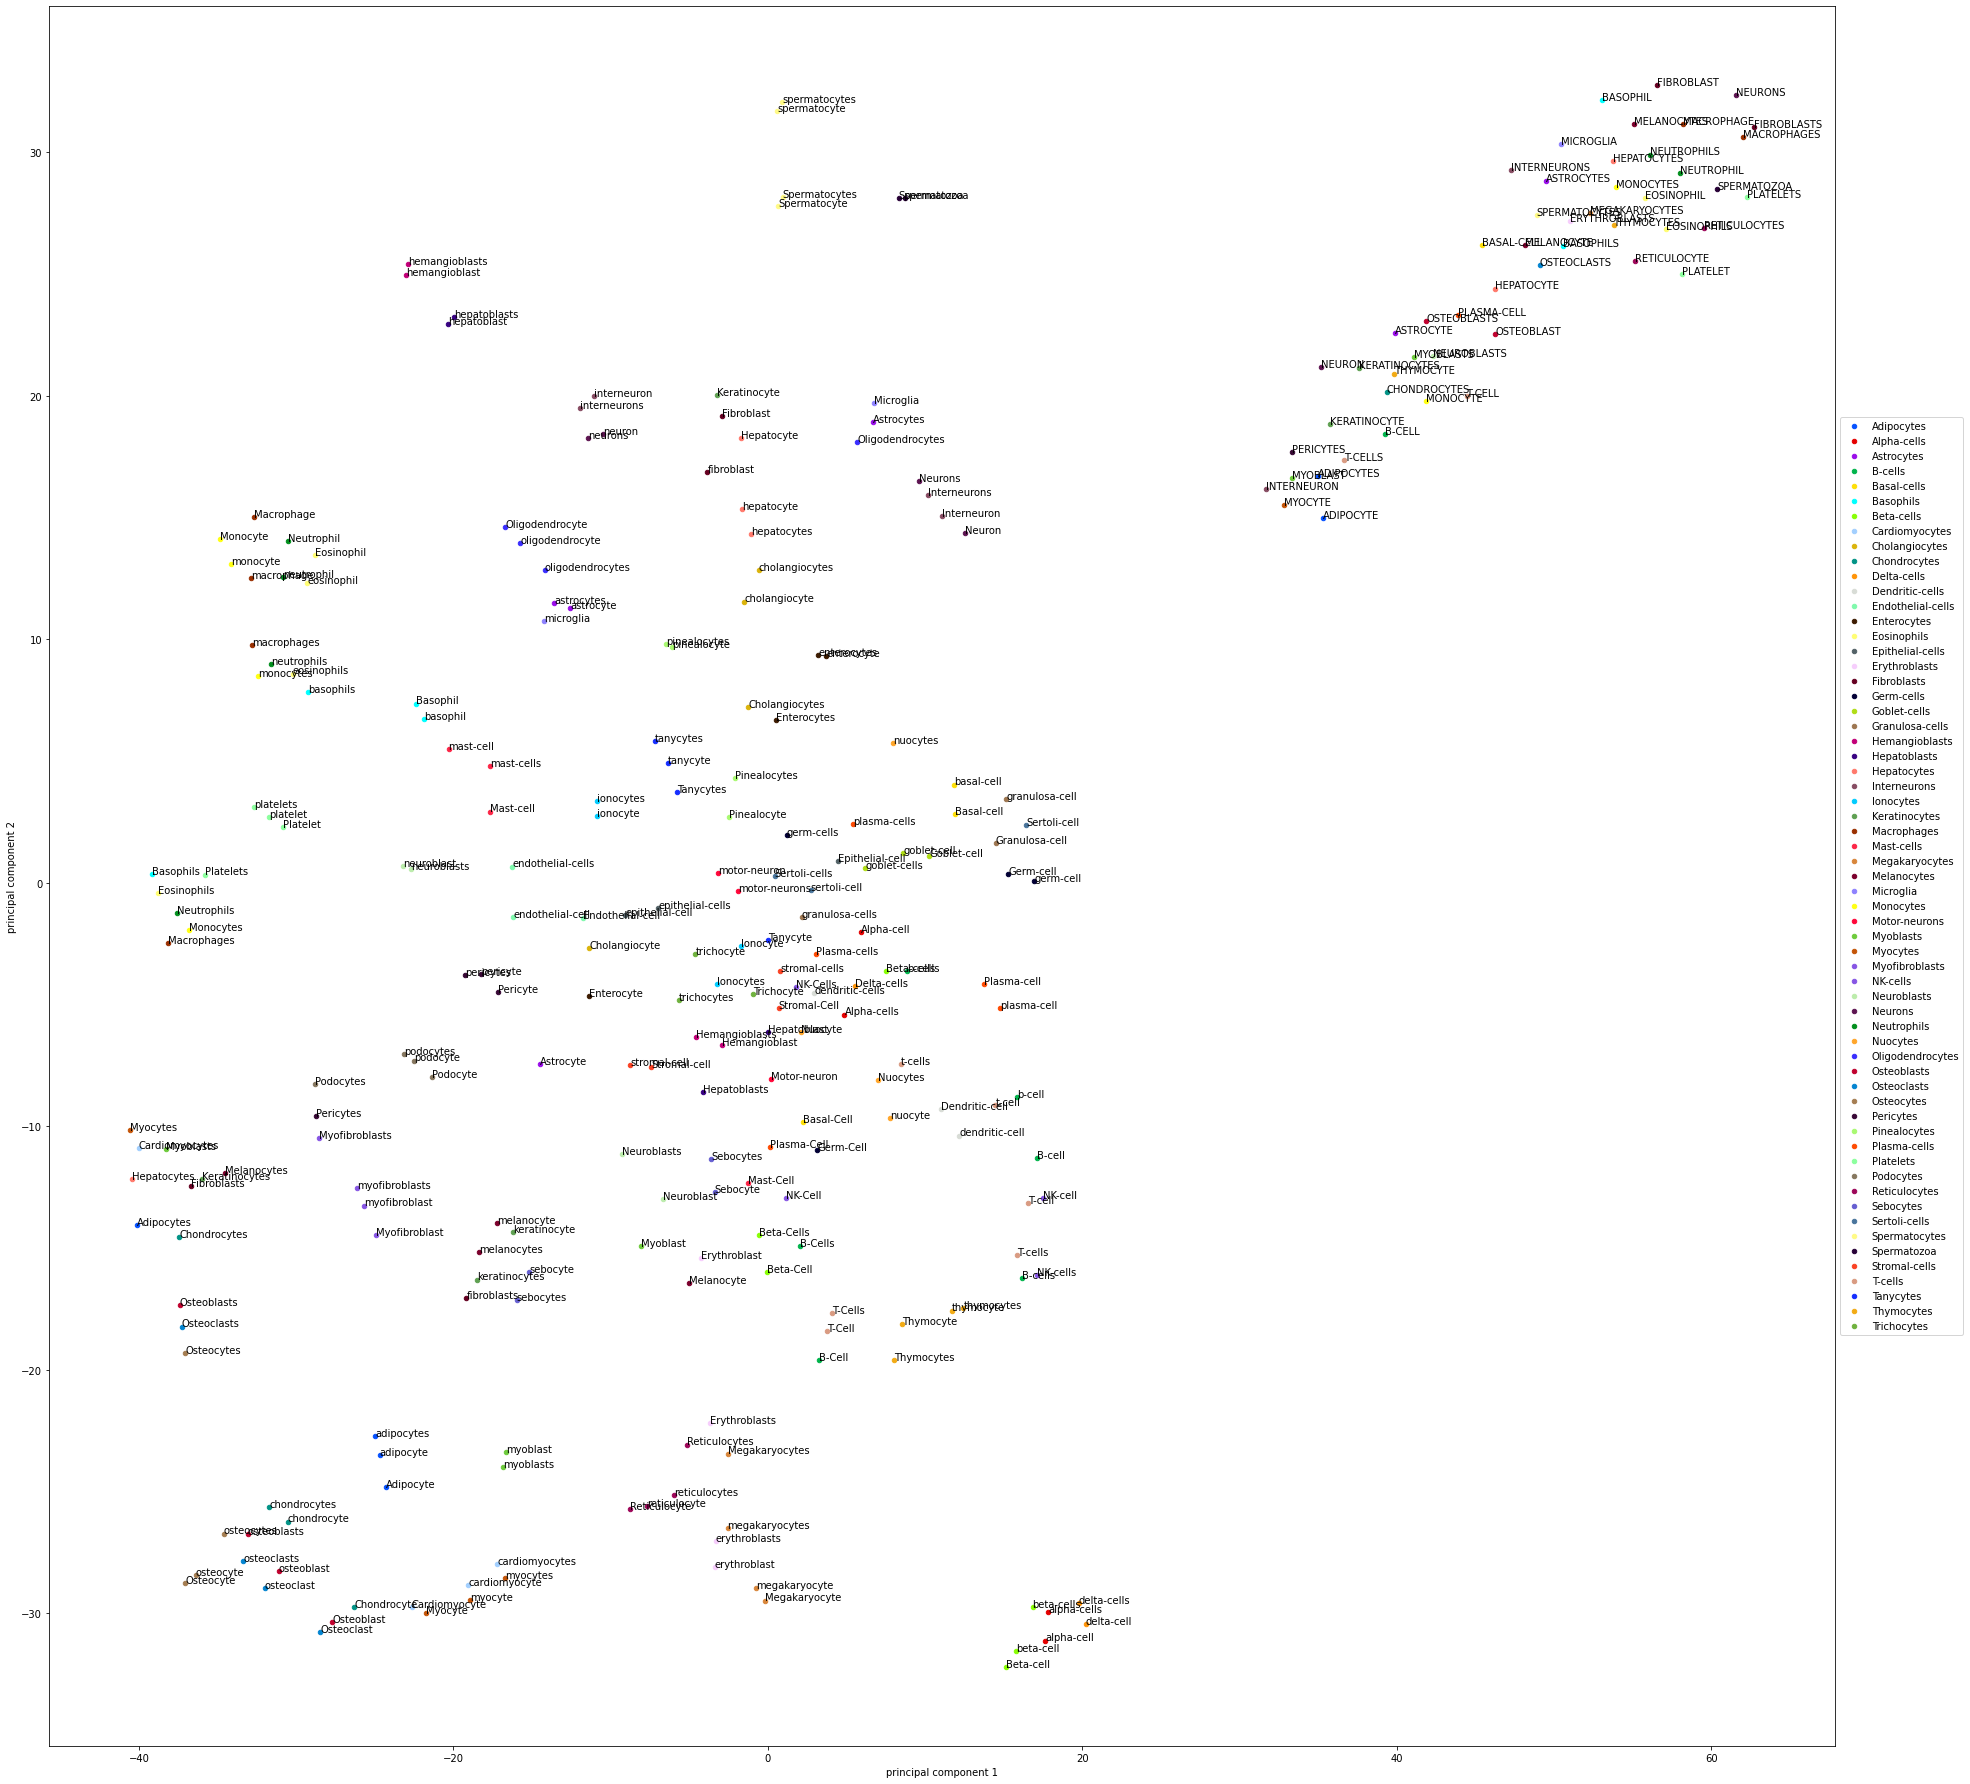

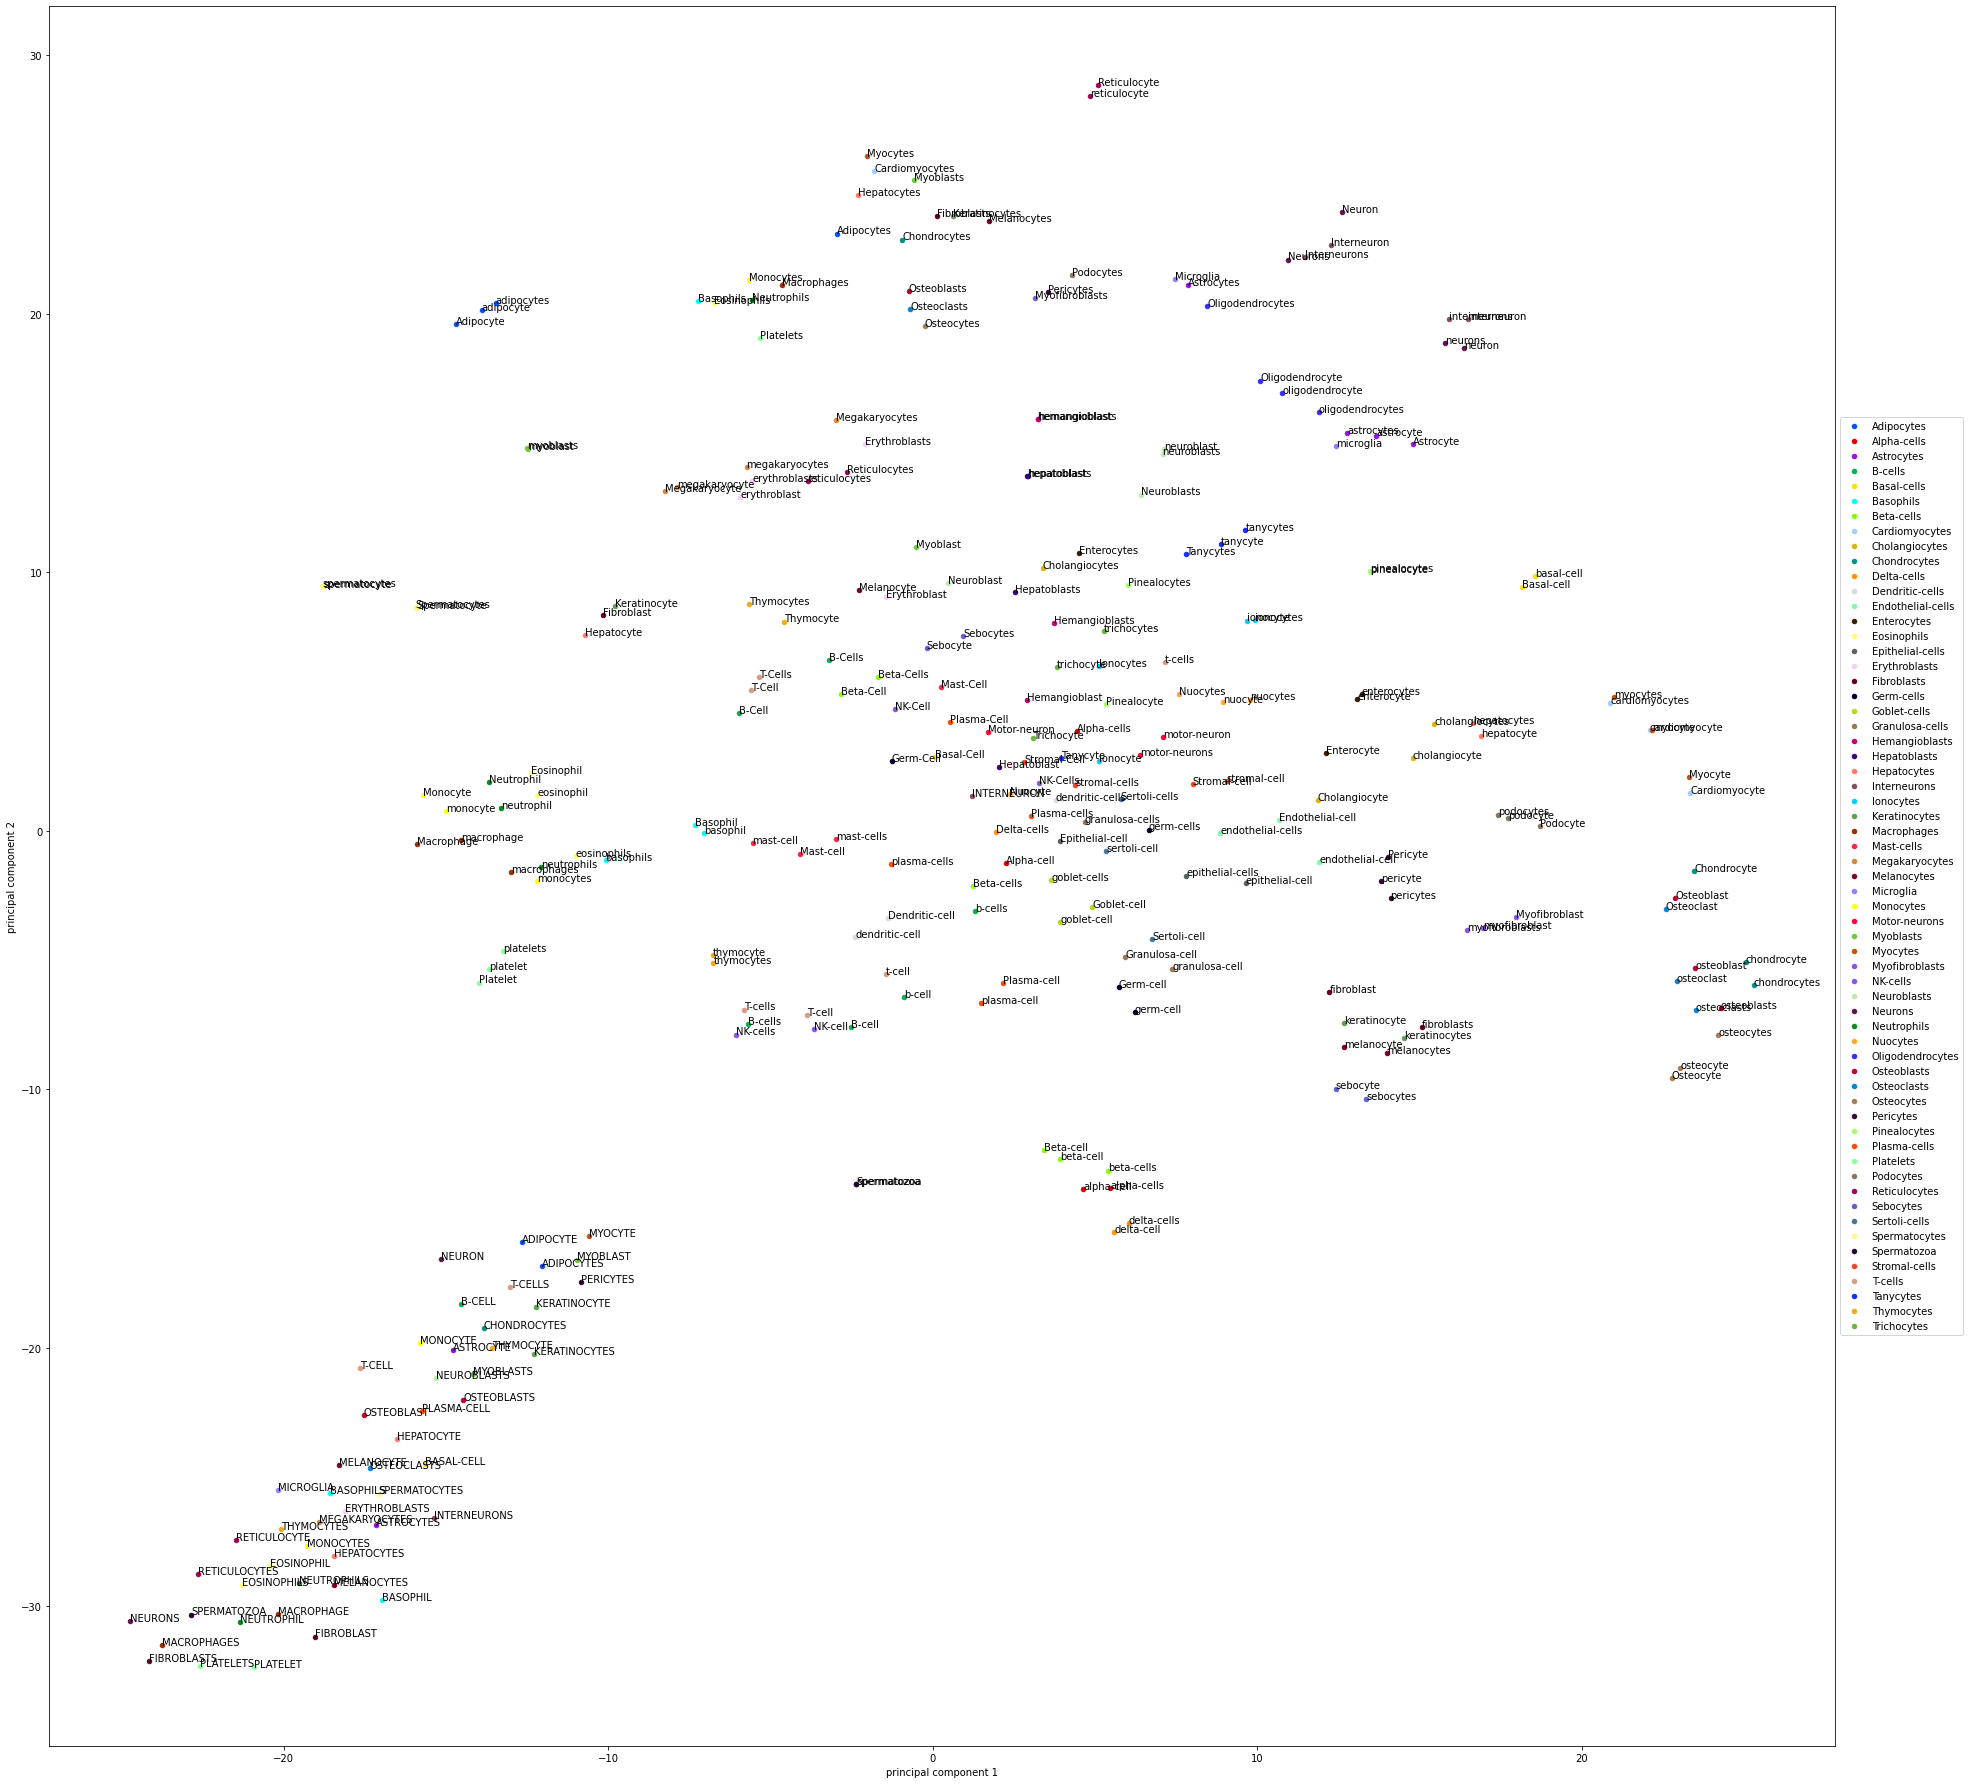

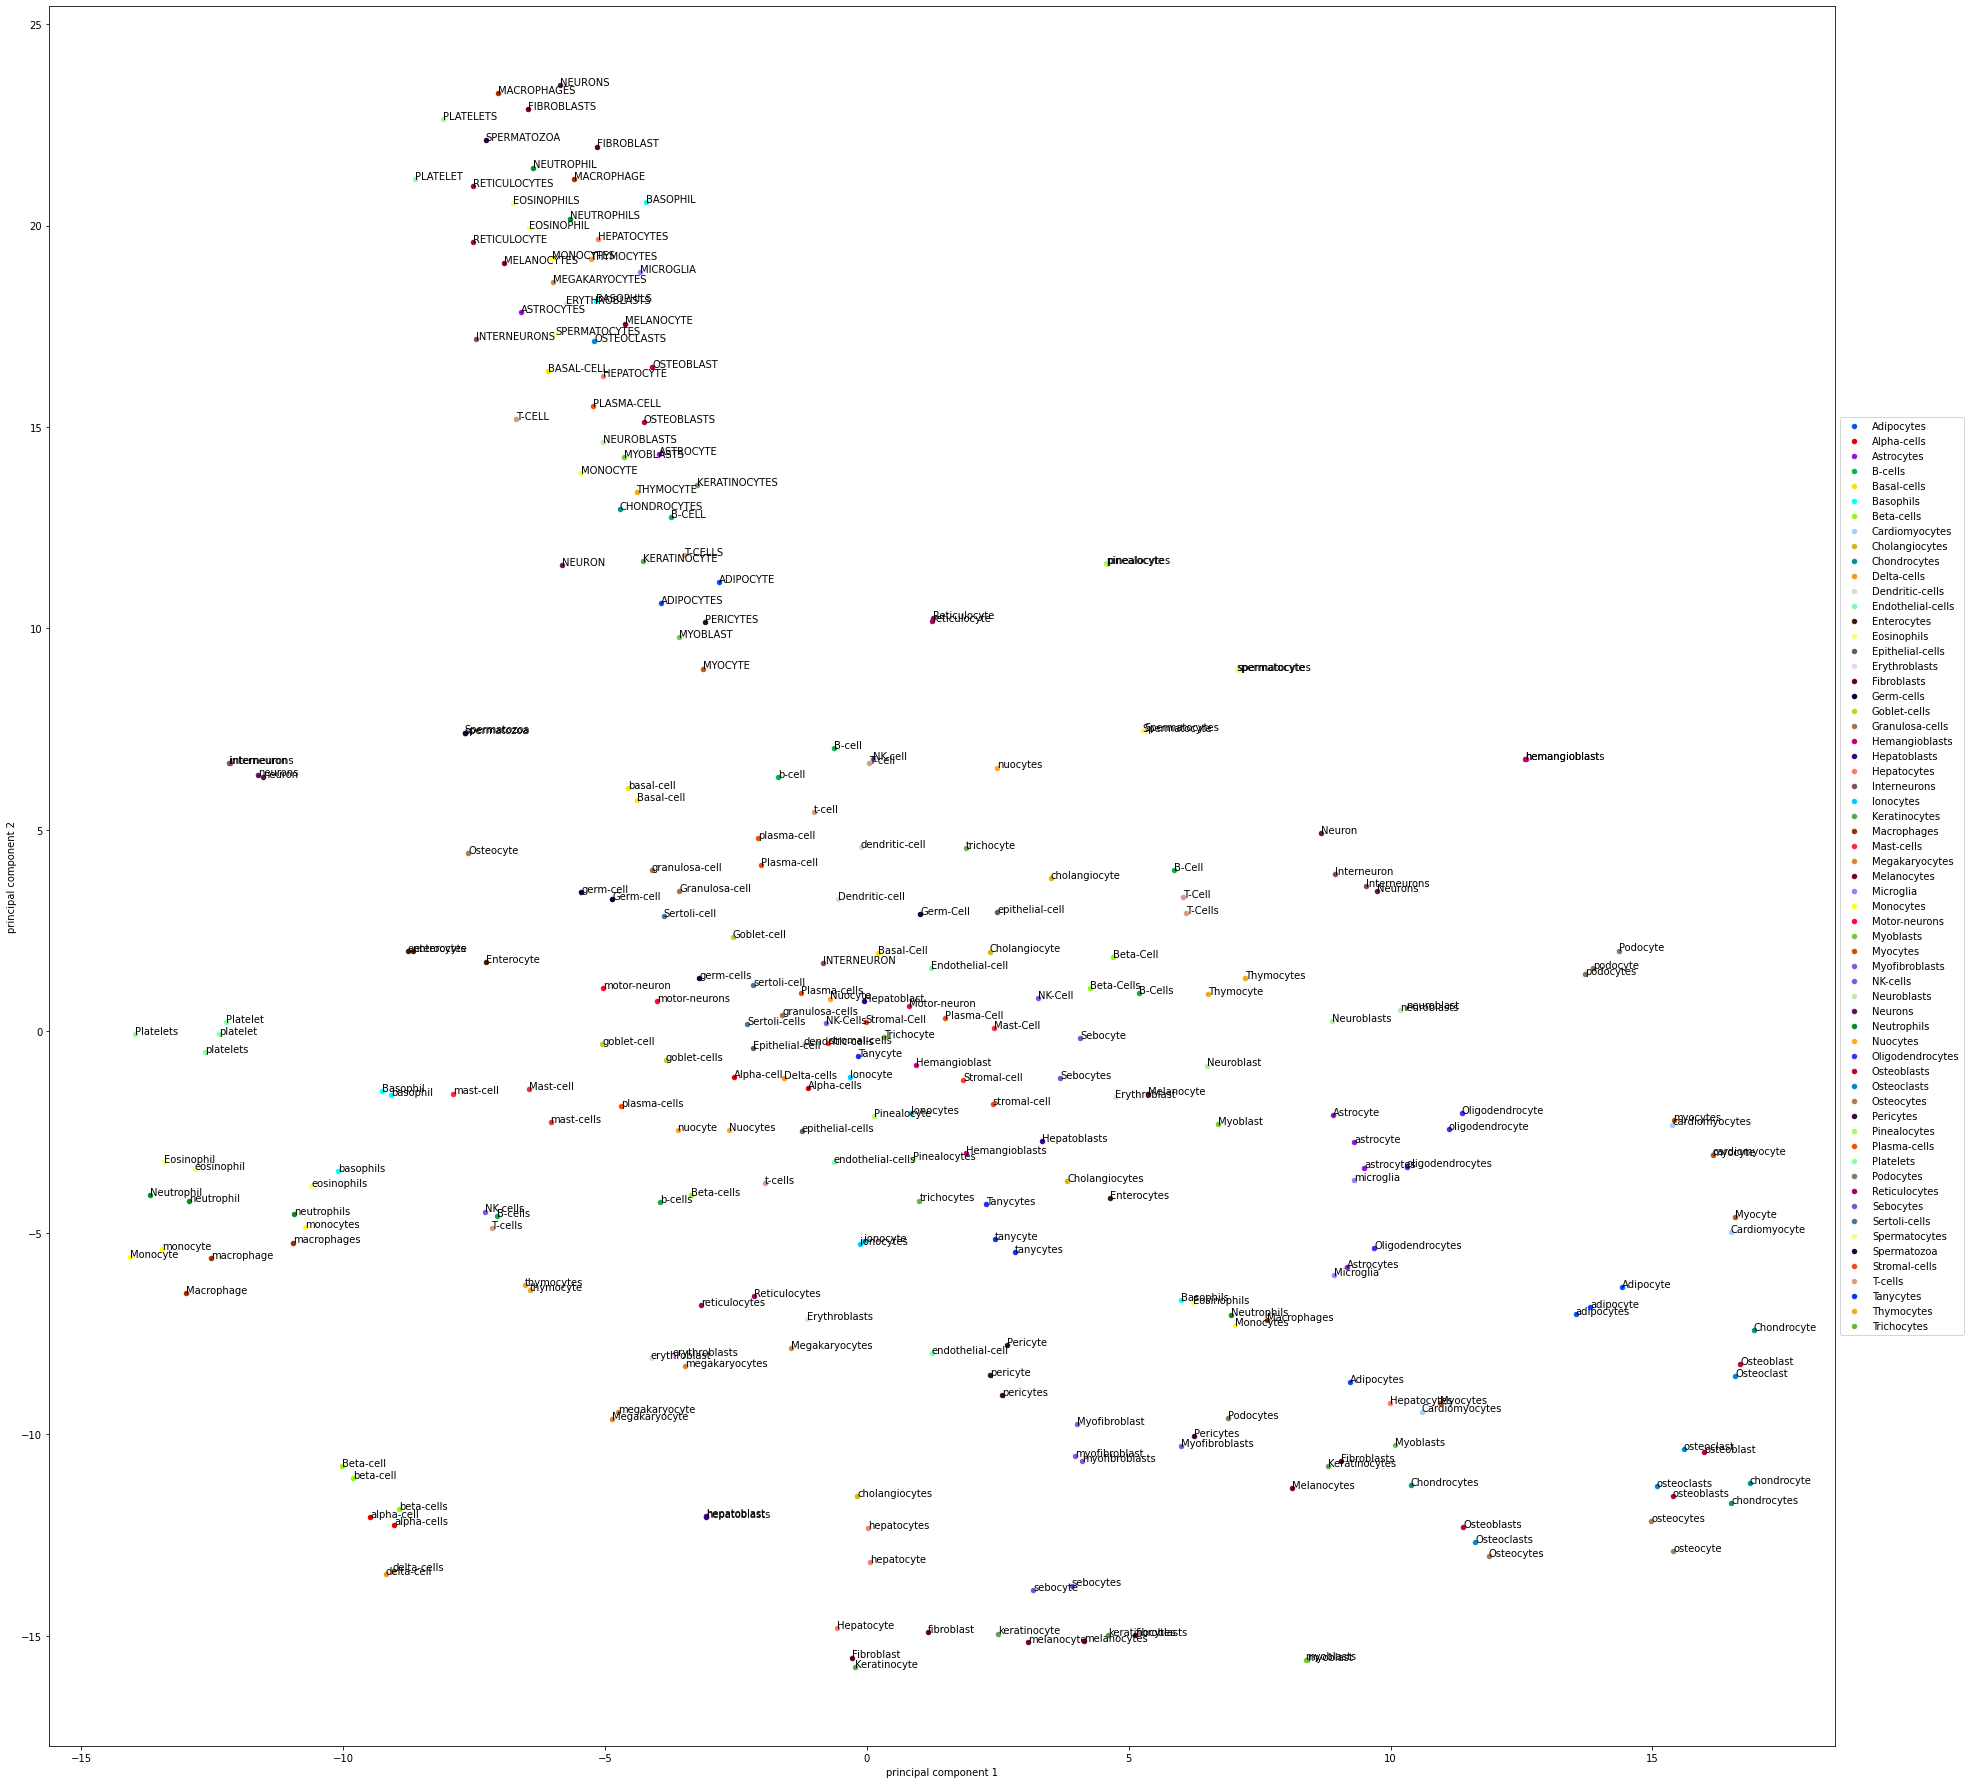

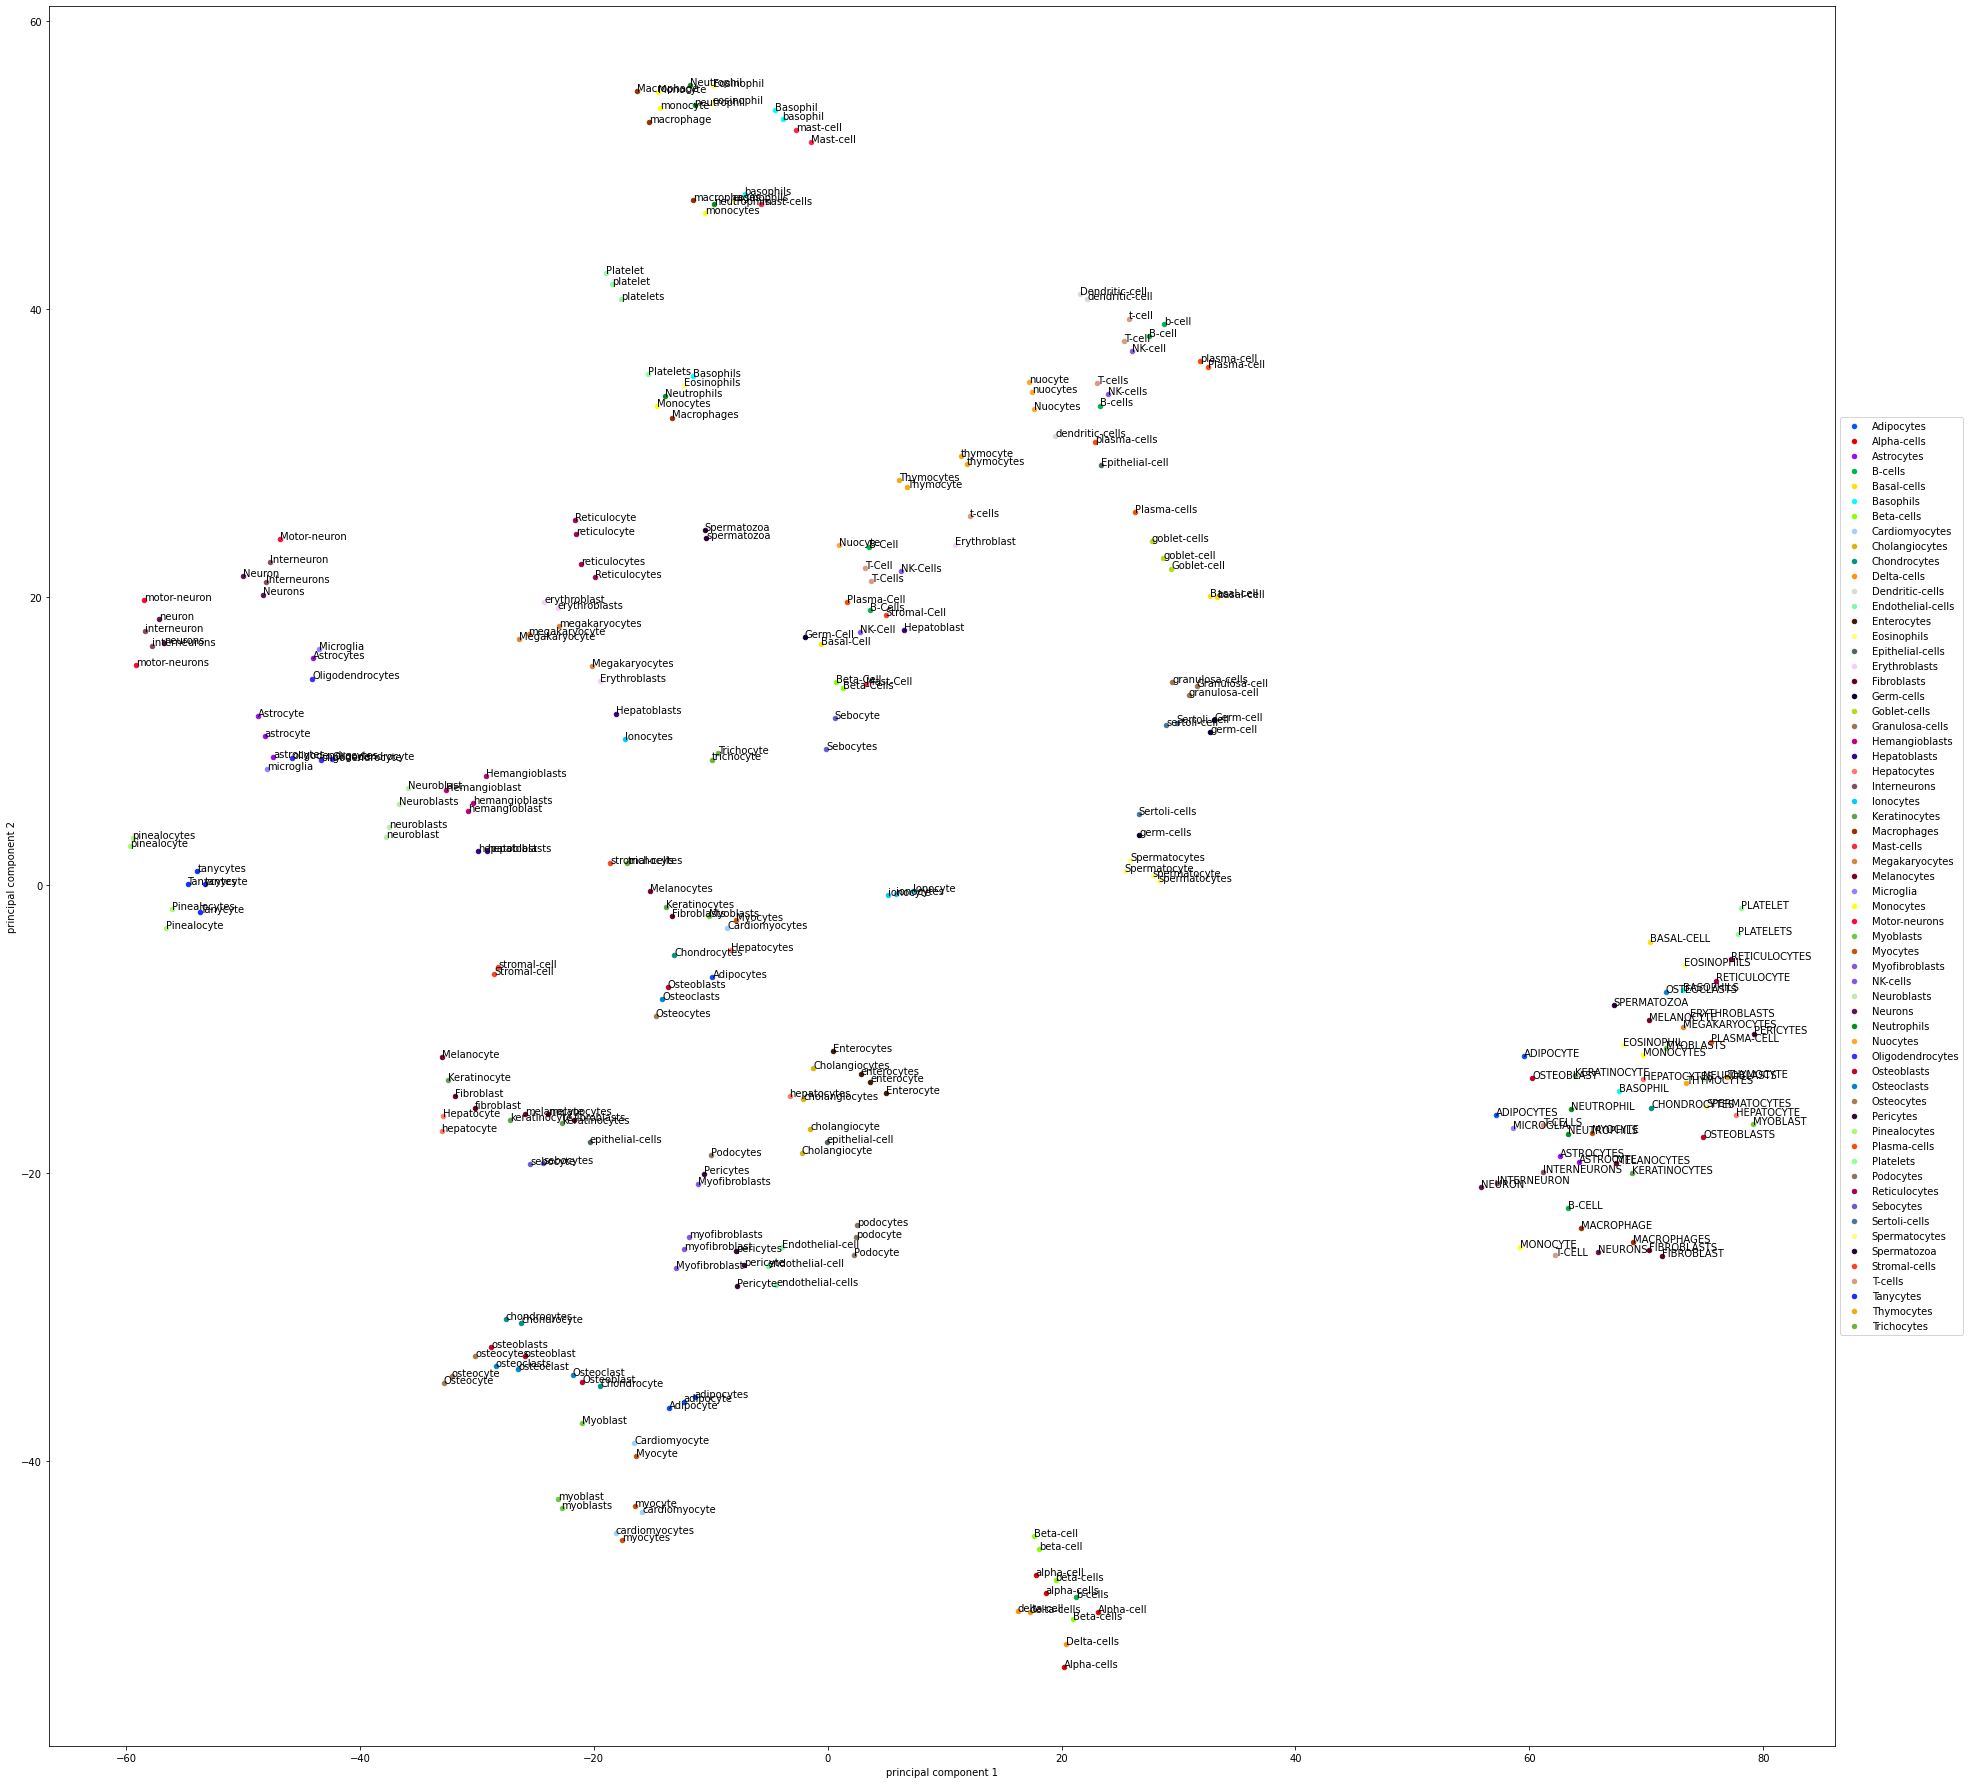

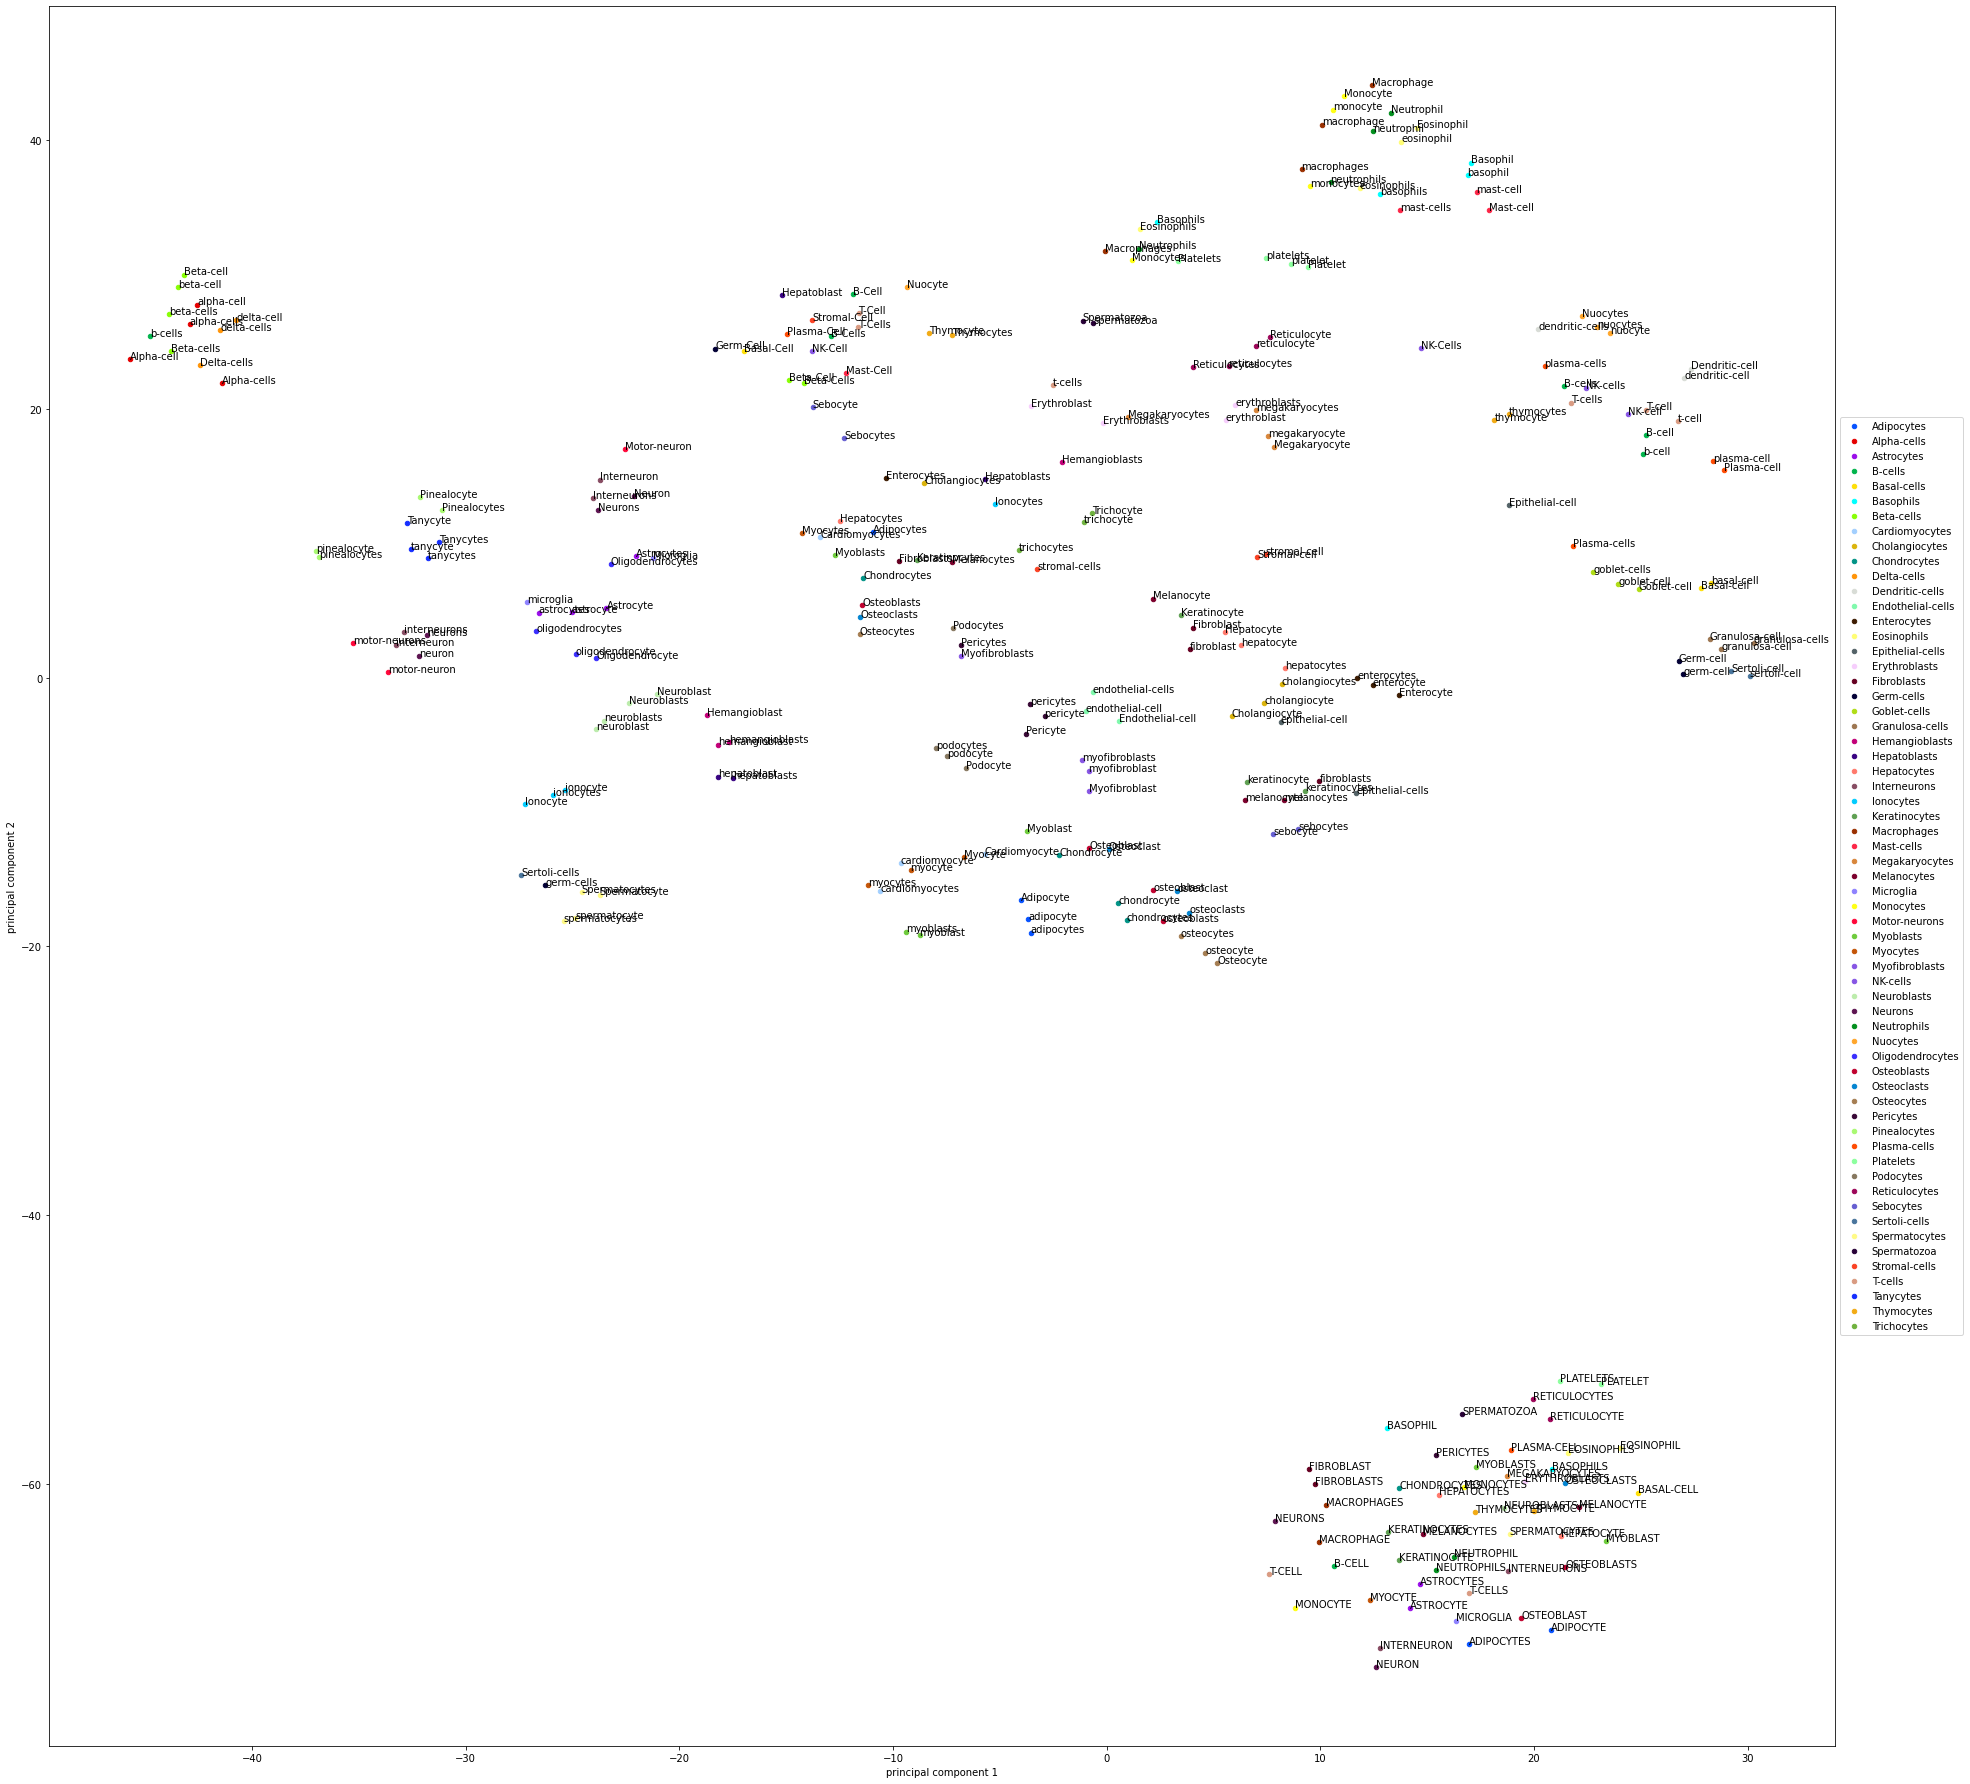

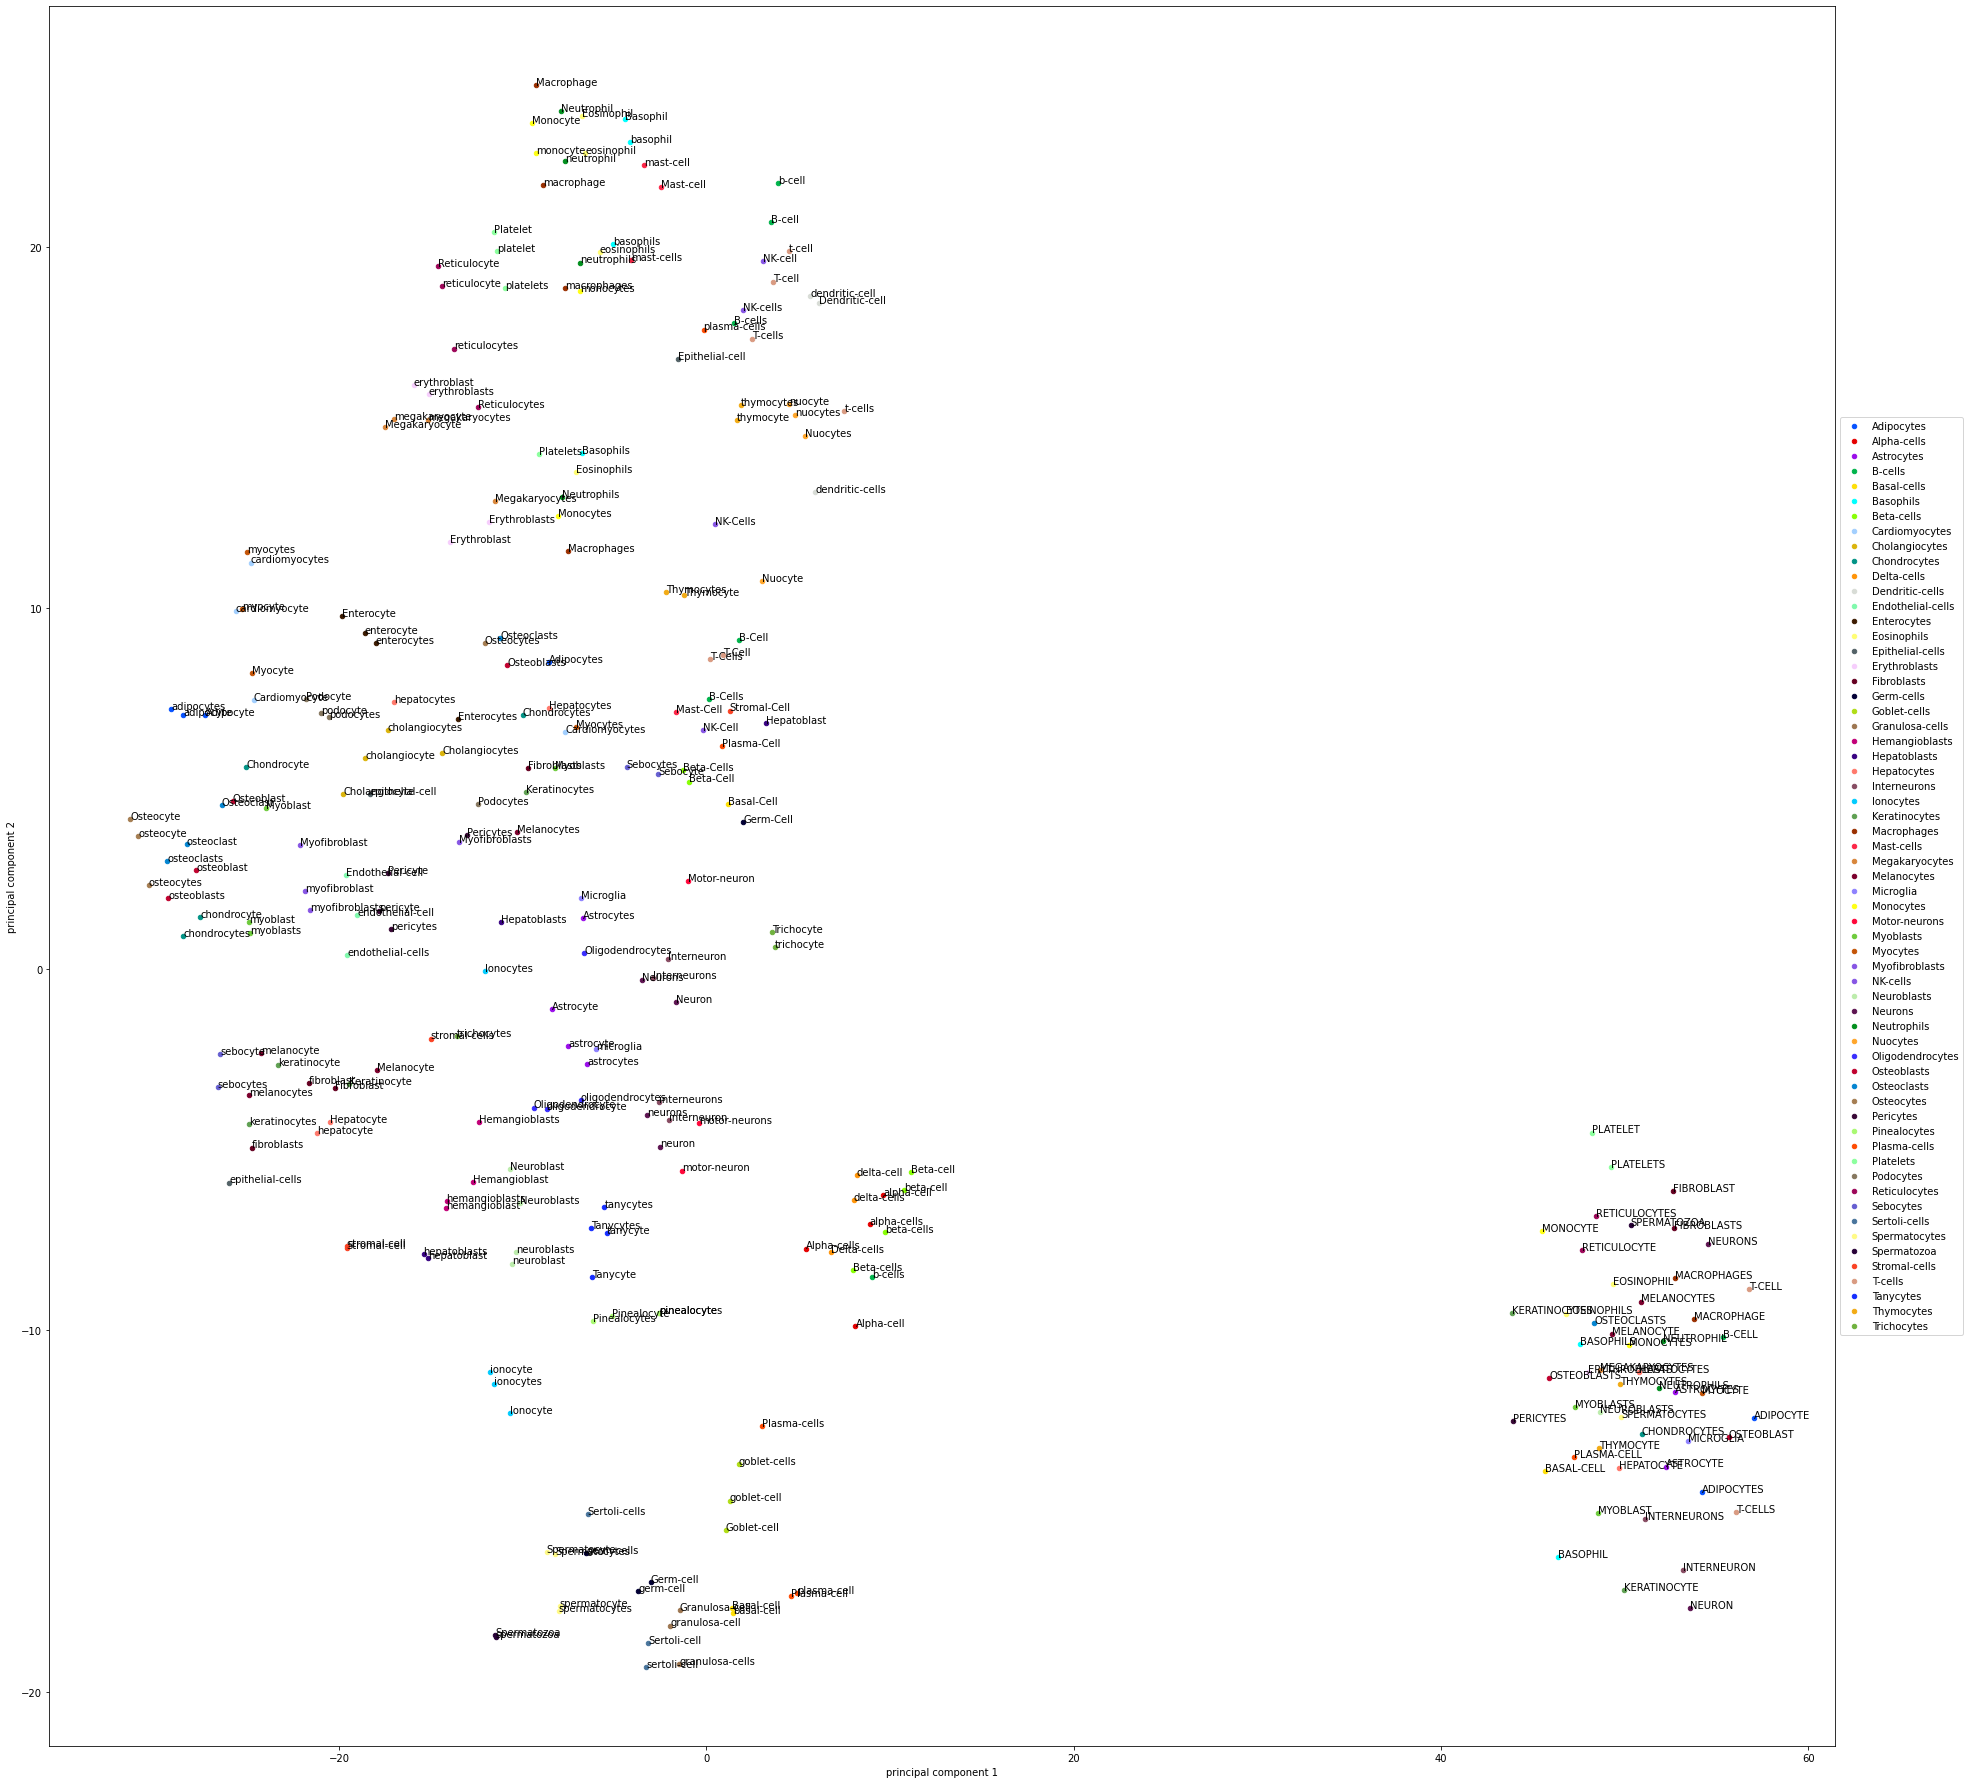

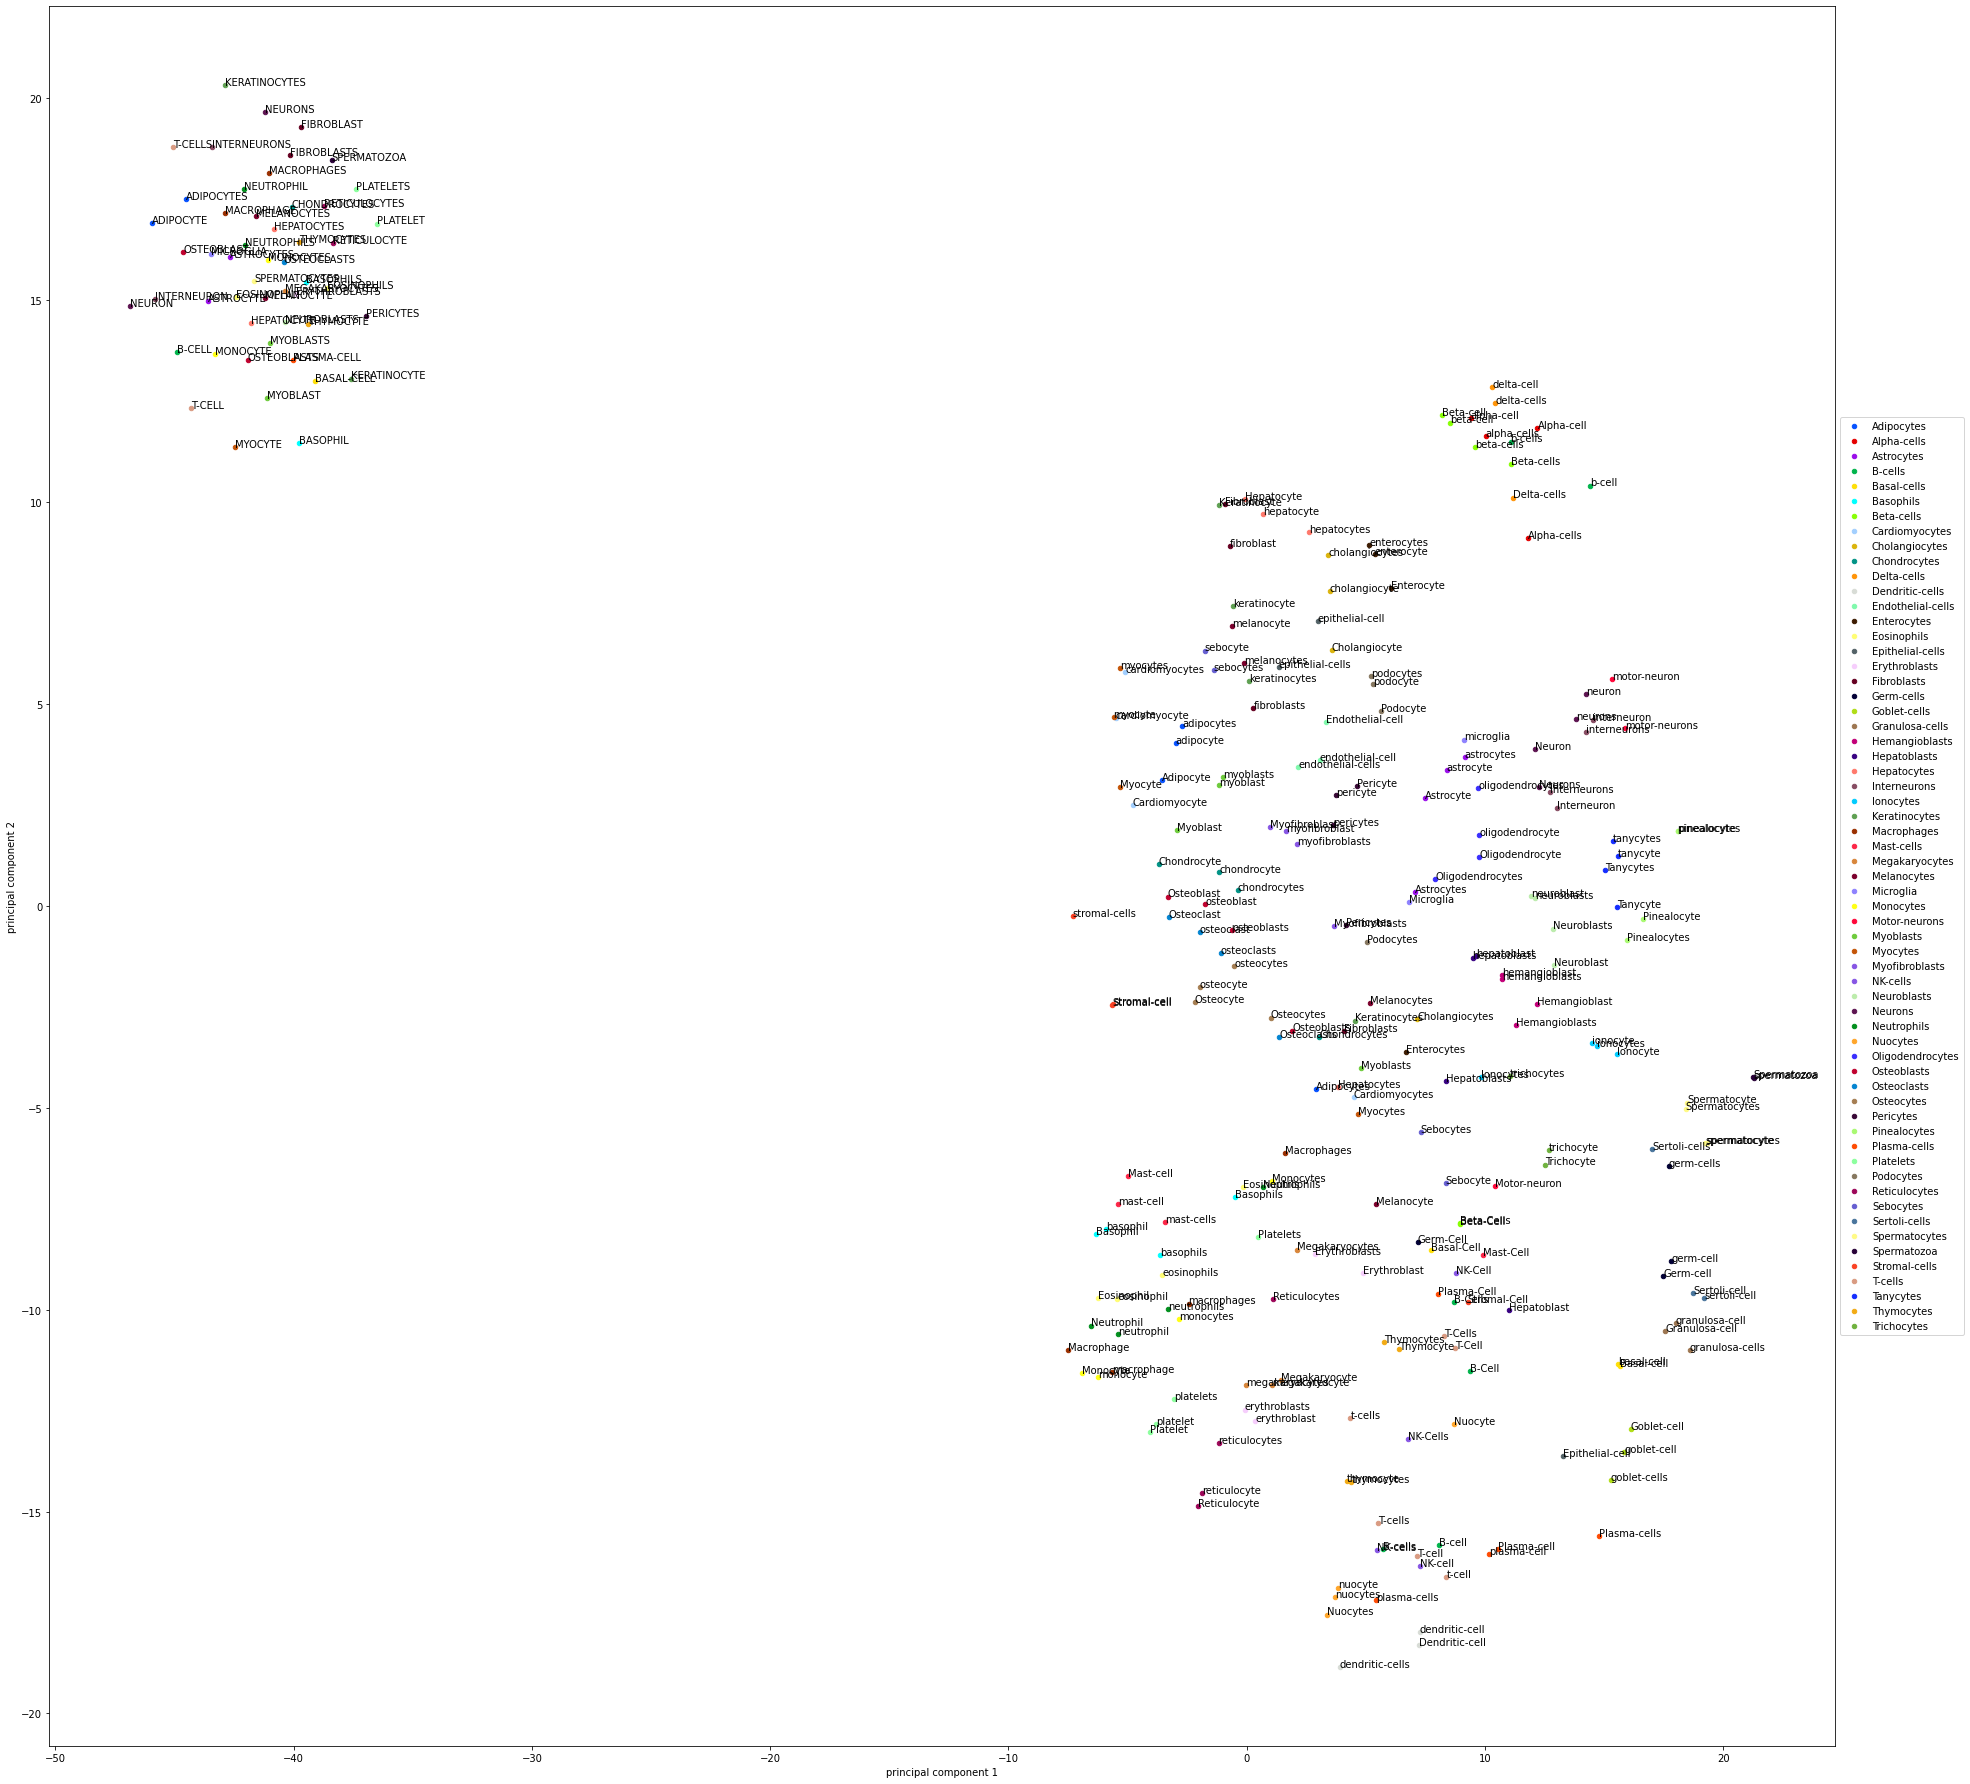

In [20]:
for metric in ["euclidean", "cosine"]:
    for perplexity in [5, 10, 20, 30]:
        tSNE(vectors, labels, df_cell_vecs[['origin']], metric, perplexity)

#### Combine PCA with tSNE

In [21]:
# Reduce the dimentionality of data from 200D to 50D using PCA first, then feed the 50D data 
# into TSNE and reduce the data to 2D. Try different perplexity settings (5, 10, 20, 30) in the TSNE step. 
def pcatsne(vectors, labels, origin, perplexity):
    columns = []
    for i in range(1,51):
        columns.append('principal component ' + str(i))
    pca = PCA(n_components=50)
    principalComponents = pca.fit_transform(vectors)
    tsne = TSNE(n_components=2, perplexity = perplexity)
    principalComponentsTSNE = tsne.fit_transform(principalComponents)
    principalDfTSNE = pd.DataFrame(data = principalComponentsTSNE
             , columns = ['principal component 1', 'principal component 2'], index = labels)
    finalDfTSNE = pd.concat([principalDfTSNE, origin], axis = 1)
    groupsTSNE = finalDfTSNE.groupby("origin")
    fig, ax = plt.subplots()
    i = 0
    for name, group in groupsTSNE:
        group.plot(kind="scatter", x = "principal component 1", y = "principal component 2", 
                   ax=ax, marker="o", label=name, color=MANY_COLORS[i])
        i += 1
    for index, row in finalDfTSNE.iterrows():
        ax.annotate(index, (row["principal component 1"], row["principal component 2"]))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    figure = plt.gcf()
    figure.set_size_inches(32, 32)
    plt.savefig("img/PCA_TSNE.euclidean." + str(perplexity) + ".png")

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


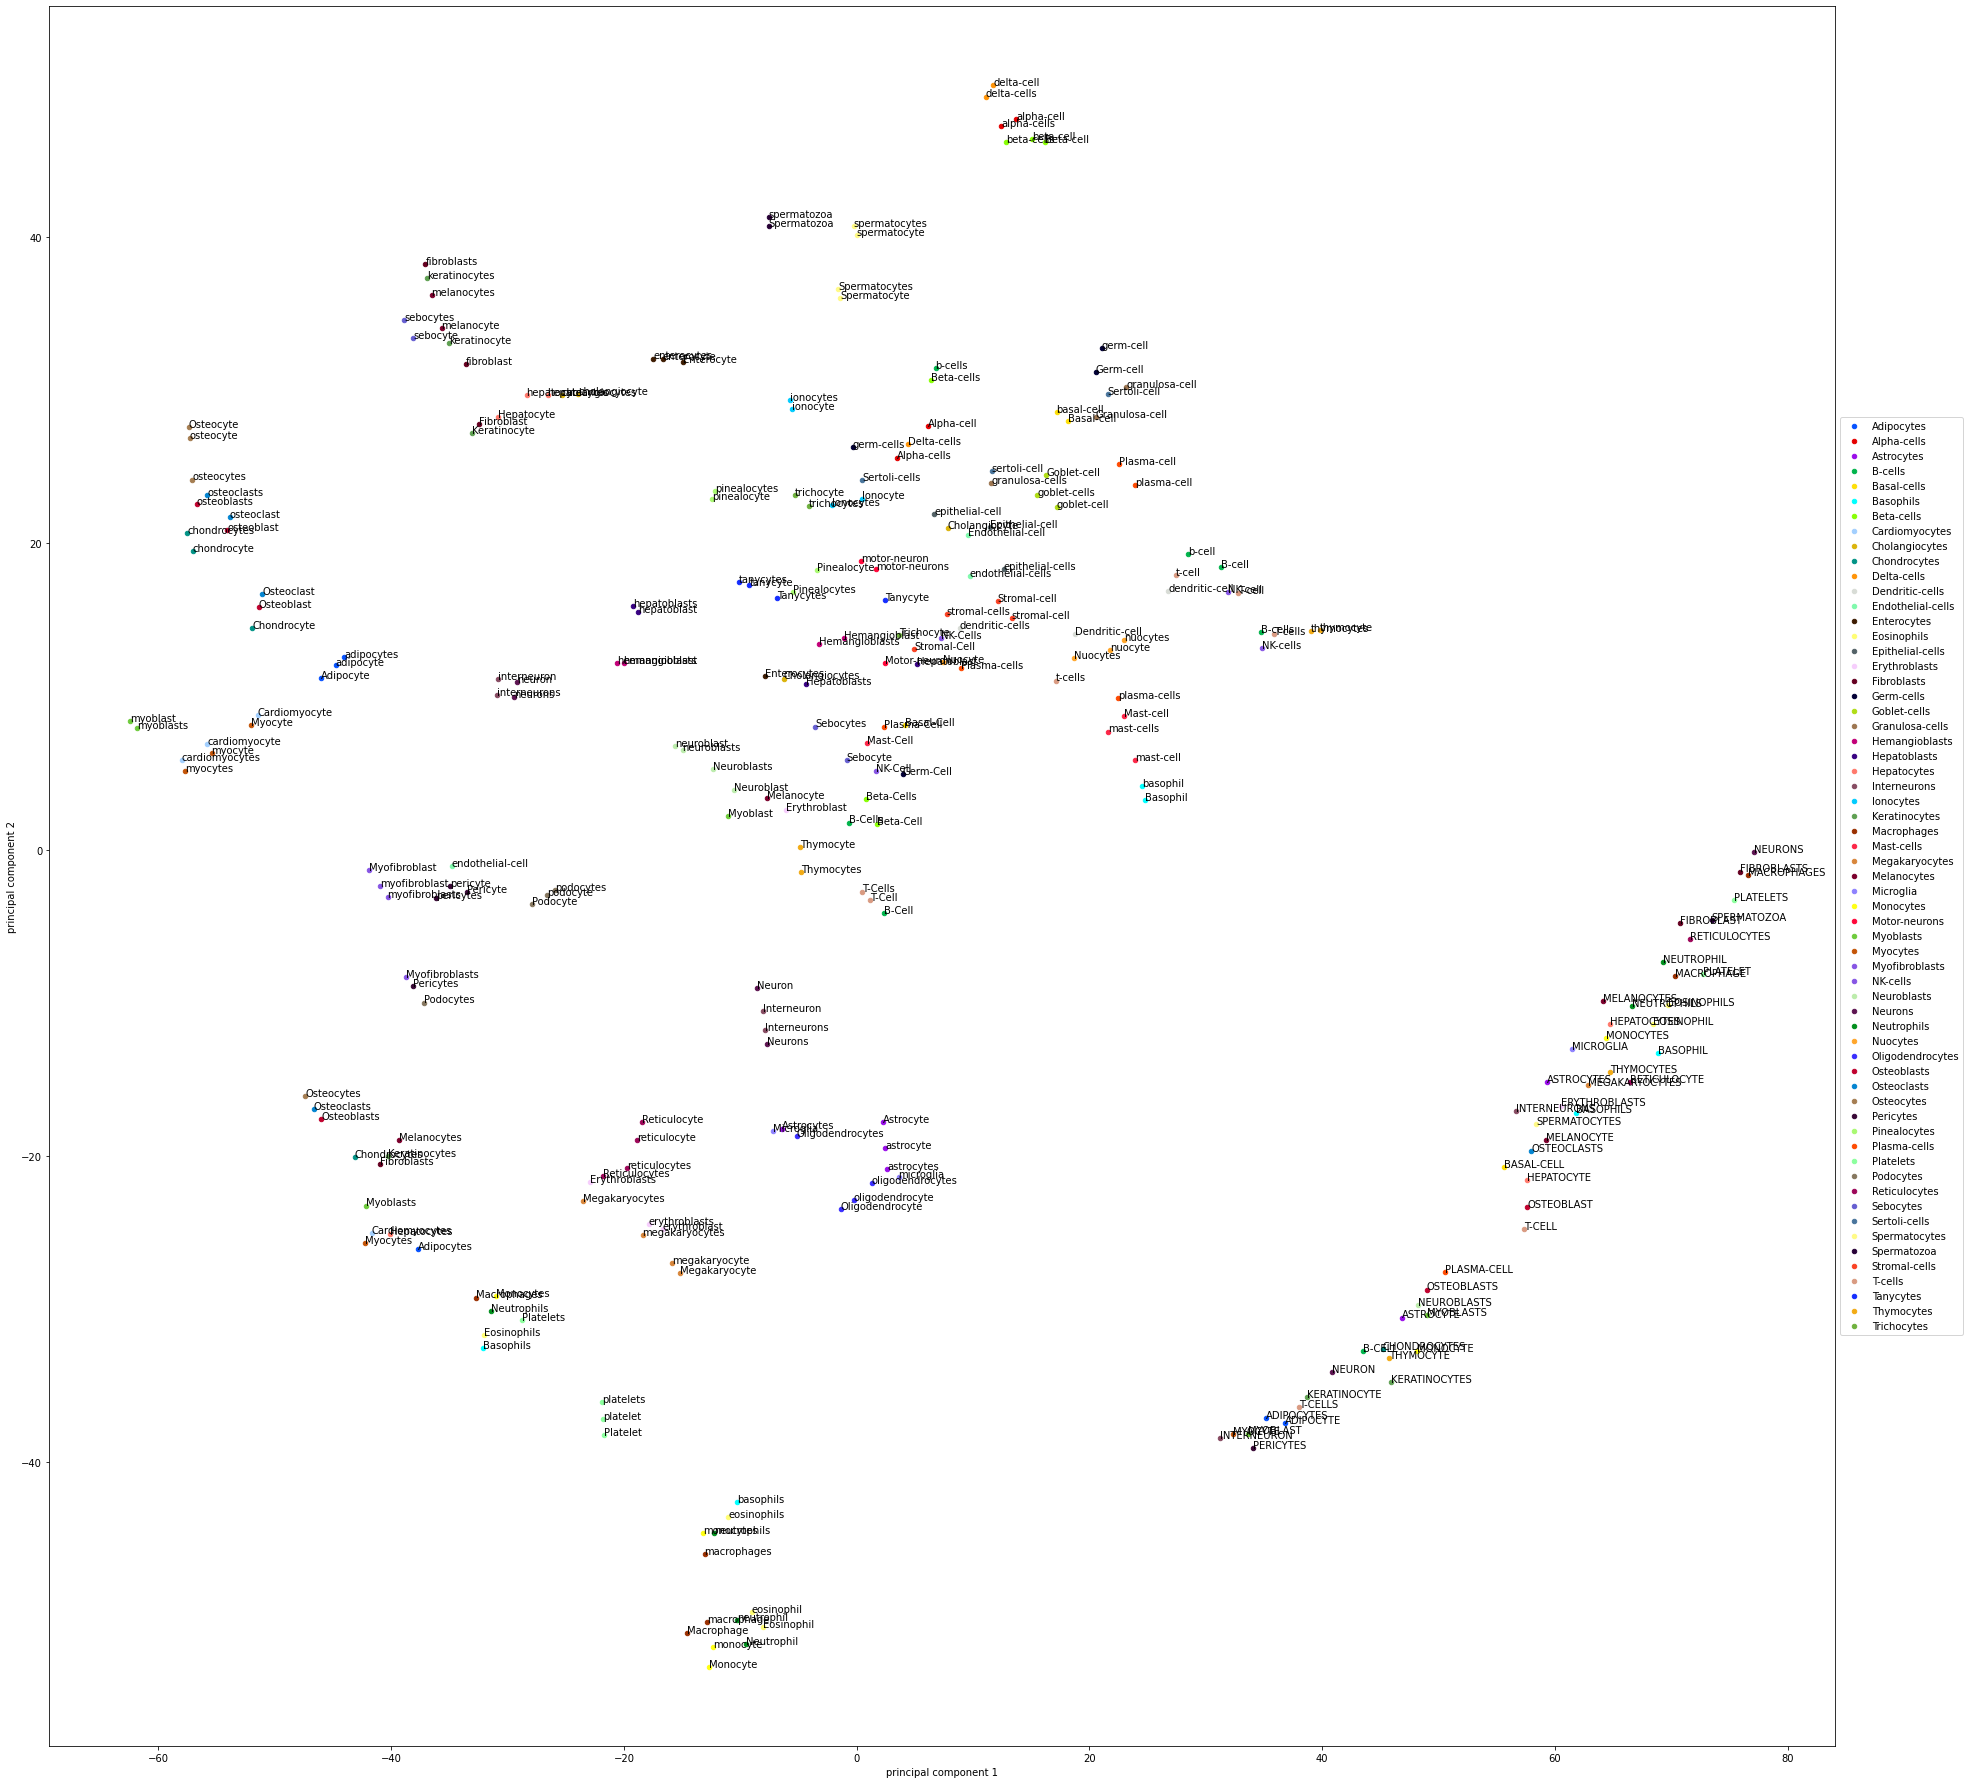

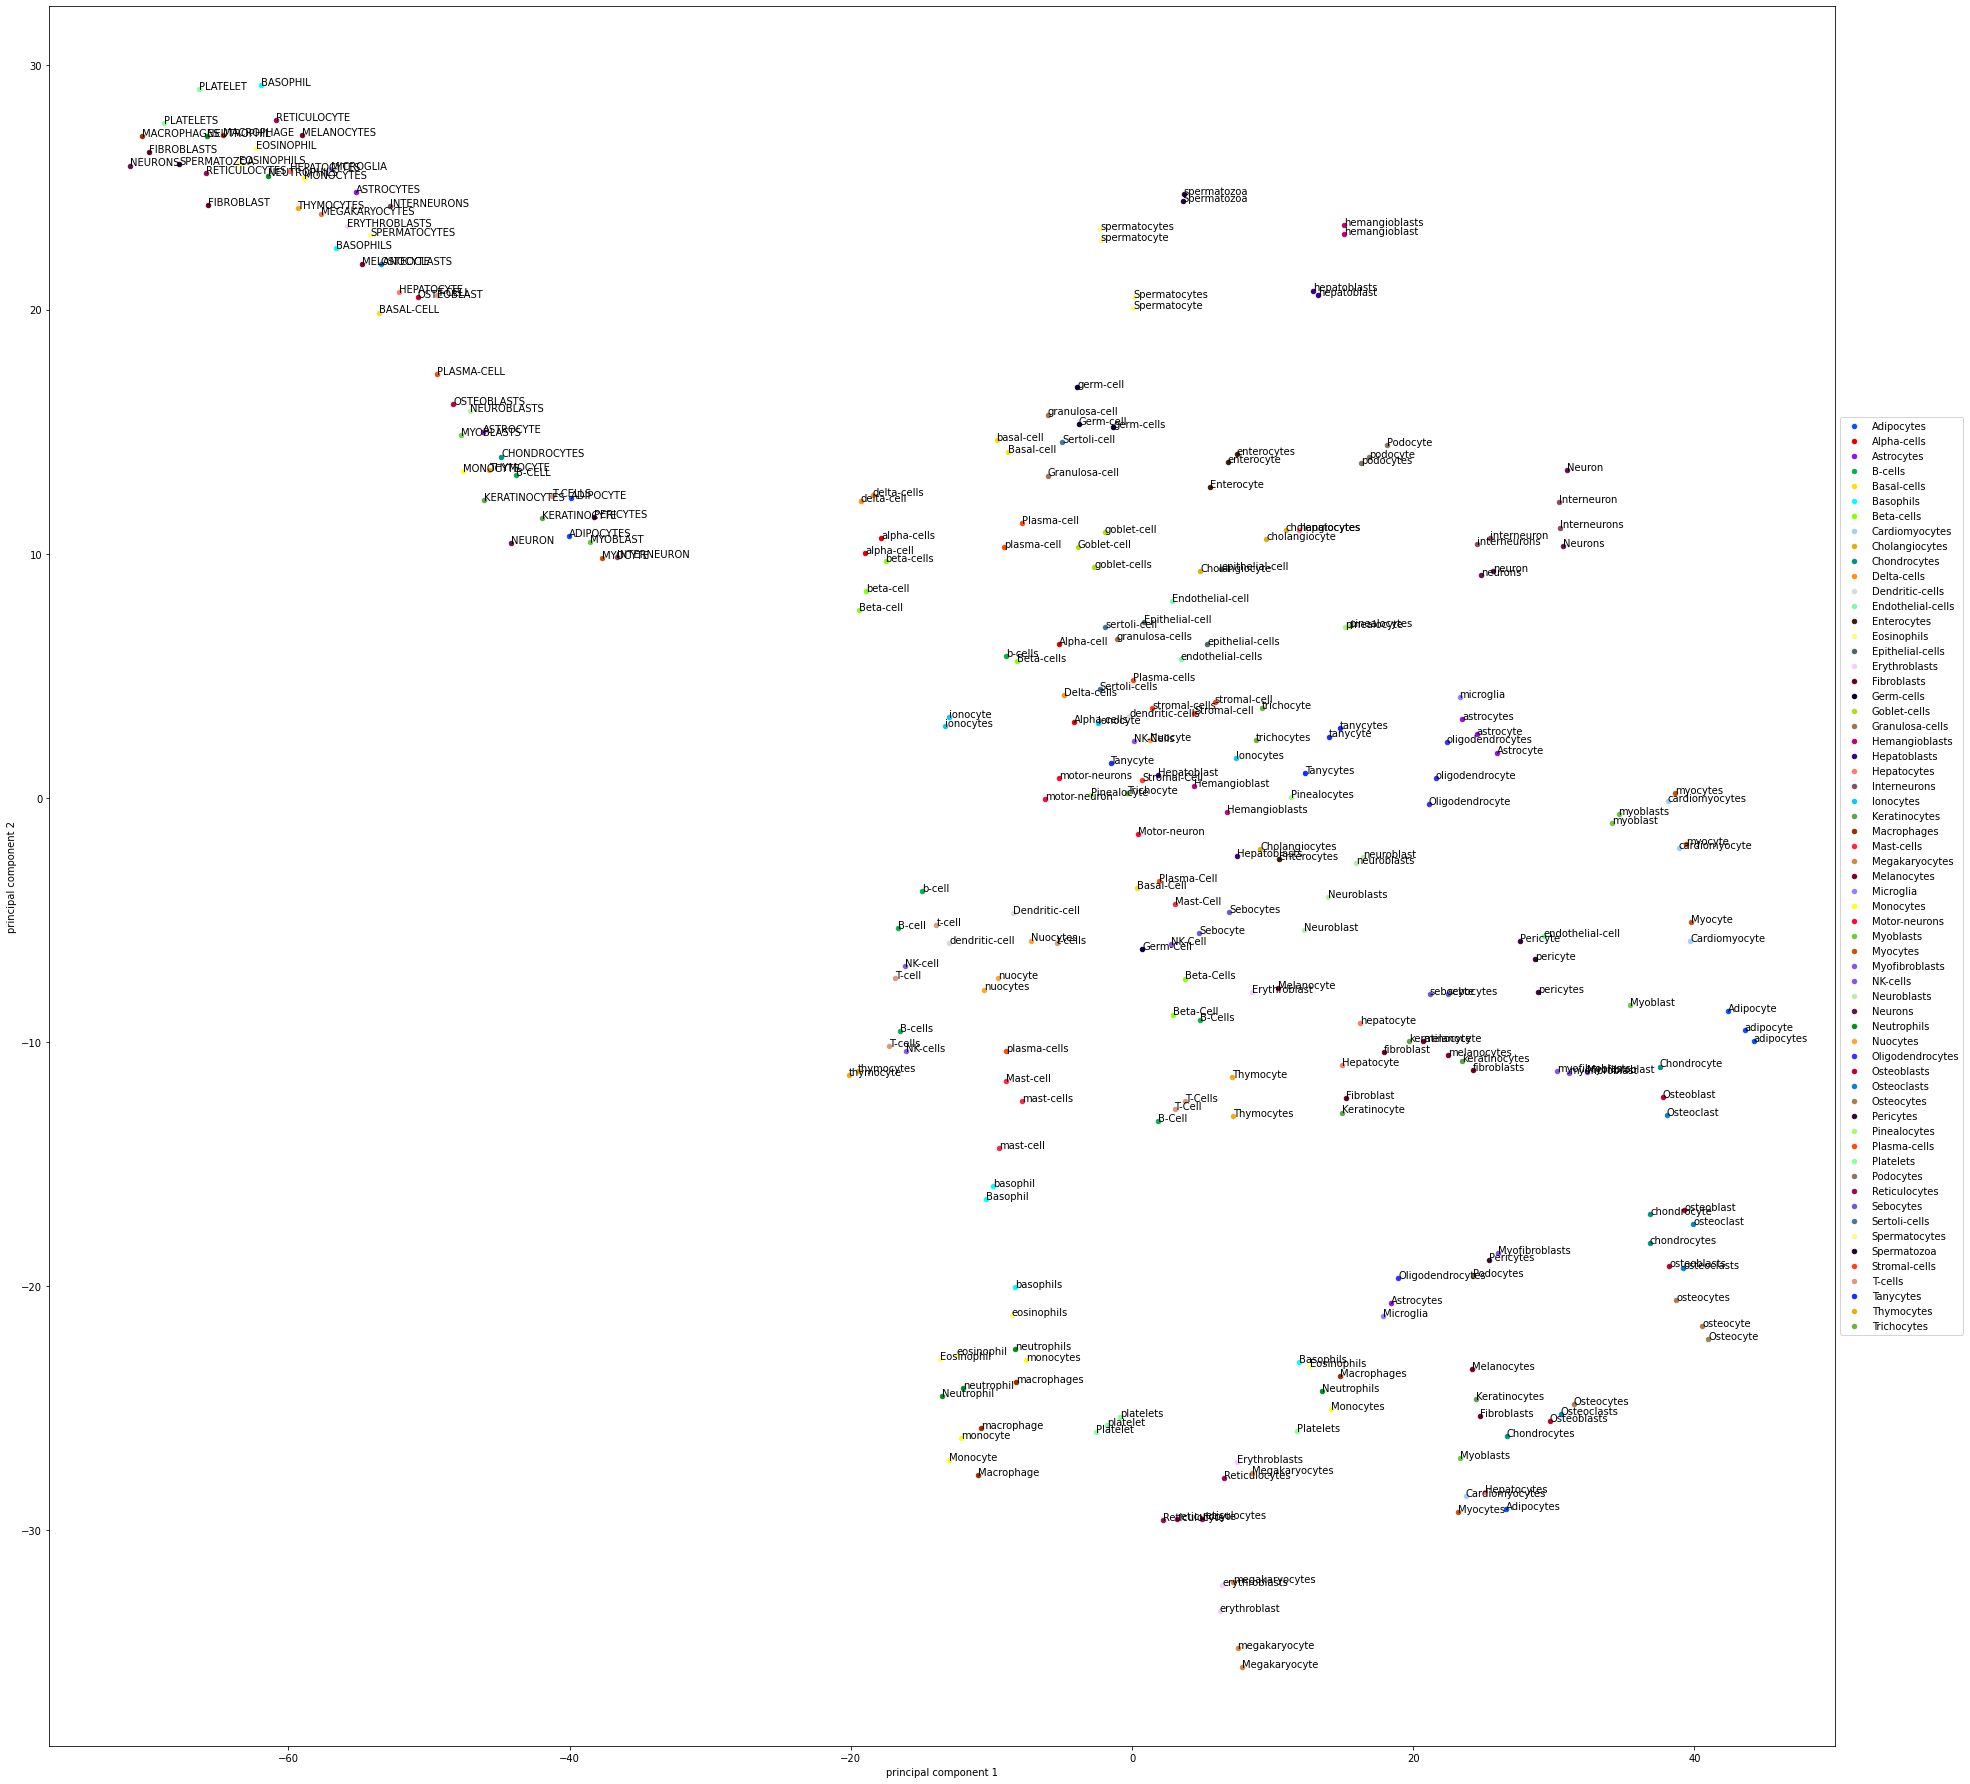

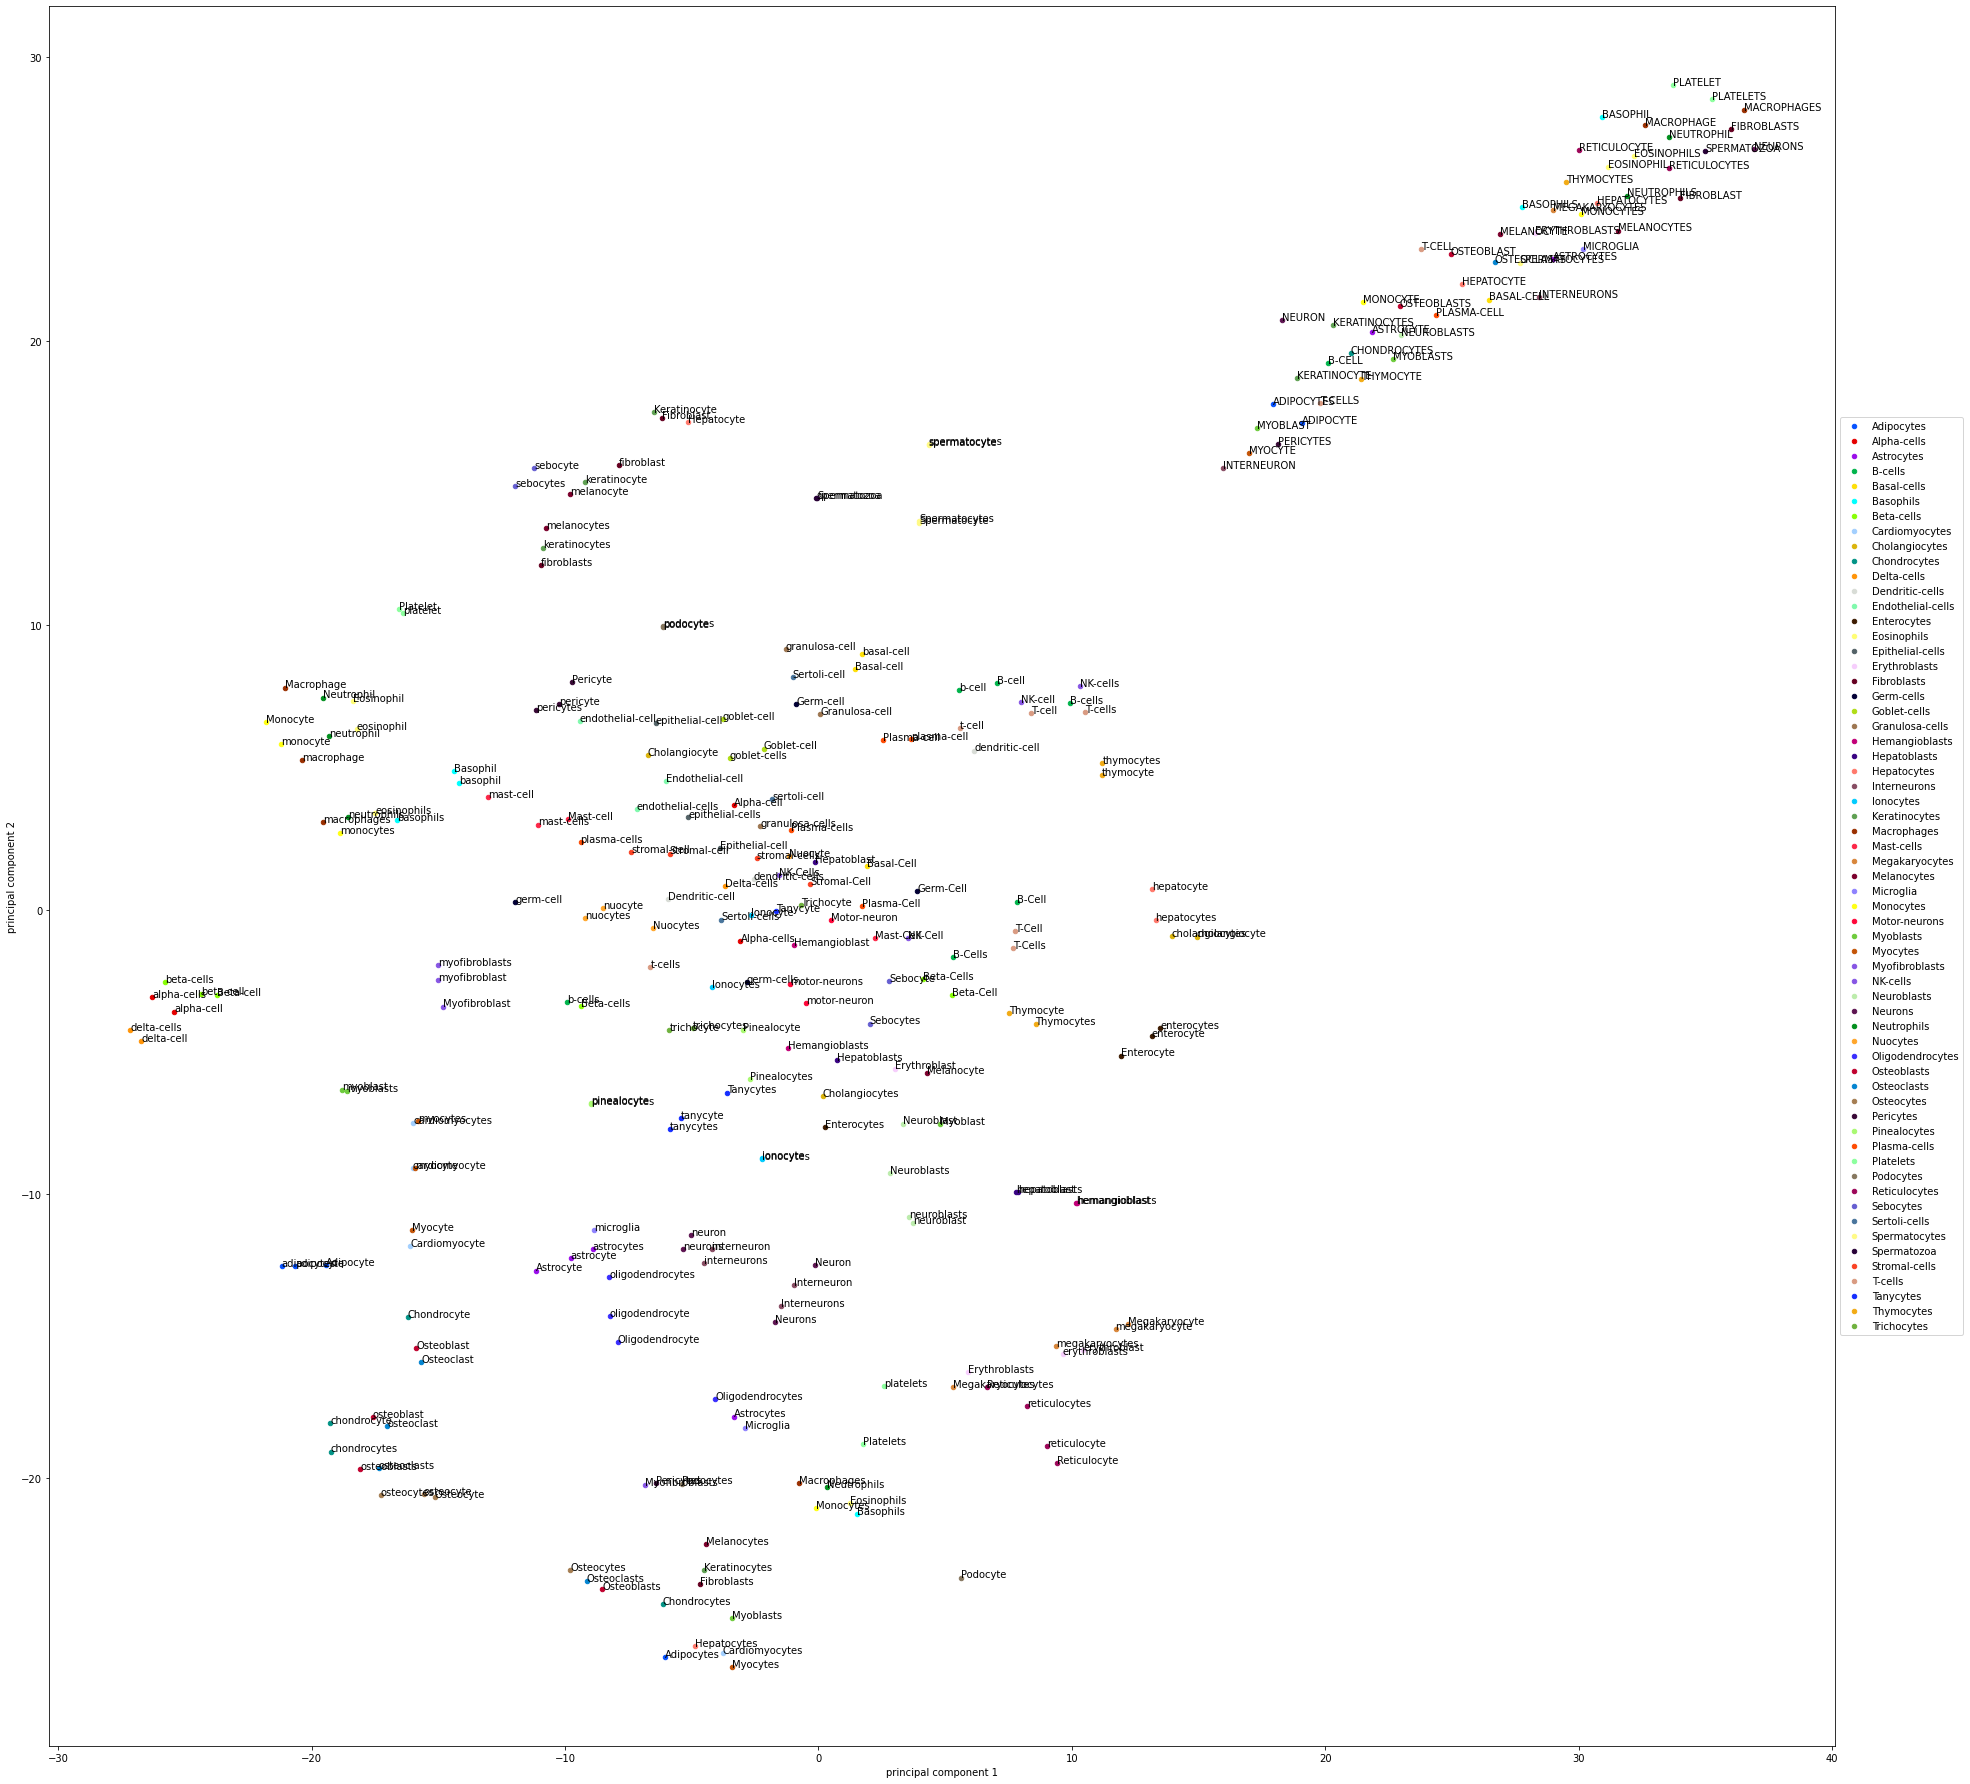

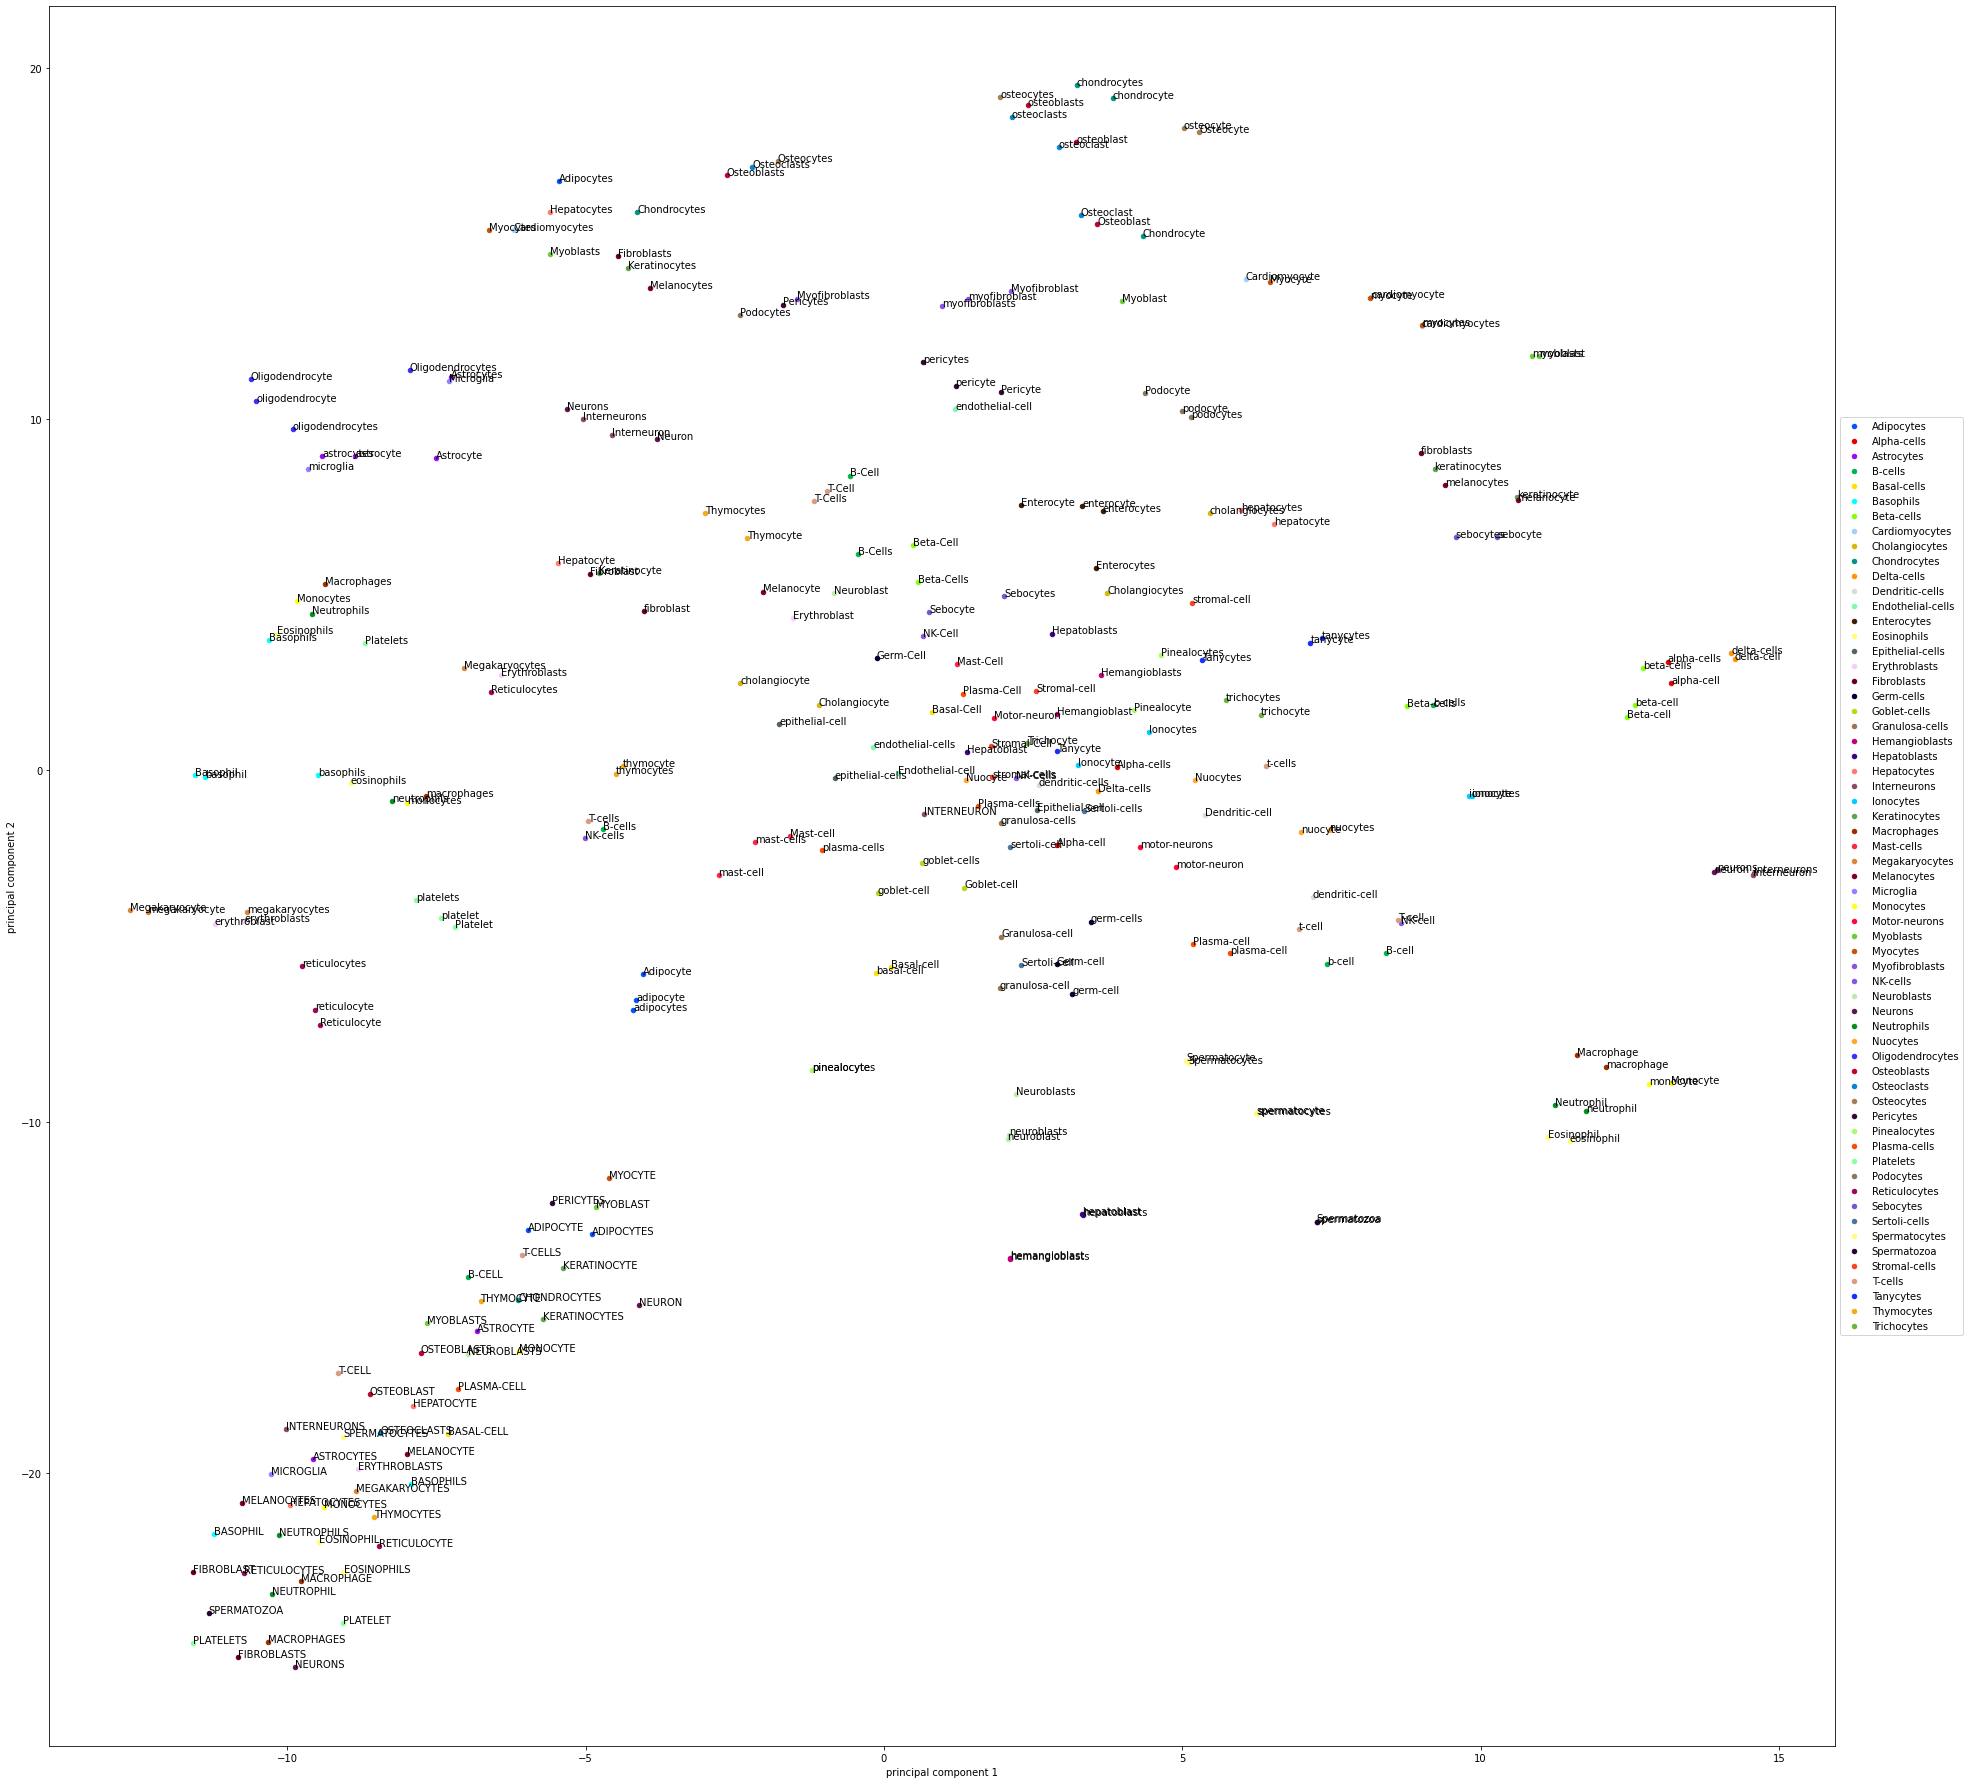

In [22]:
for perplexity in [5, 10, 20, 30]:
    pcatsne(vectors, labels, df_cell_vecs[['origin']], perplexity)